# **Carbon Dioxide Levels Prediction**

**Objective: The dataset contains monthly carbon dioxide concentration levels from 1986 till 2048 (hypothetical). We're required to predict the monthly carbon dioxide levels for the next 24 months.**

**Time series data is a type of data that consists of observations or measurements collected, recorded or sampled at specific time intervals. The data points in a time series are arranged in chronological order, with each observation associated with a specific time point or time interval.**

**✈️ Time Flies When You're Analyzing Time Series**

In [3]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from keras import layers
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.linear_model import Ridge
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.preprocessing.sequence import TimeseriesGenerator

data = pd.read_csv("train.csv")
data.head(5)

,Year,Month,Indicator,Value,Unit
0,2026,April,CO2 levels,405.67,PPM
1,2035,July,CO2 levels,423.20,PPM
2,2044,December,CO2 levels,445.10,PPM
3,2023,January,CO2 levels,396.04,PPM
4,2027,July,CO2 levels,406.57,PPM


In [ ]:
# If it has missing values?
data.isna().sum()

Year          0
Month         0
Indicator     0
Value        18
Unit          0
dtype: int64

In [ ]:
data['Indicator'].value_counts()

CO2 levels    754
Name: Indicator, dtype: int64

In [ ]:
data['Unit'].value_counts()

PPM    754
Name: Unit, dtype: int64

In [4]:
data.drop(['Indicator', 'Unit'], axis=1, inplace=True)
data.head(5)

,Year,Month,Value
0,2026,April,405.67
1,2035,July,423.20
2,2044,December,445.10
3,2023,January,396.04
4,2027,July,406.57


In [5]:
# Convert the 'Month' column to a categorical column with the correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['Month'] = pd.Categorical(data['Month'], categories=month_order, ordered=True)

# Sort the DataFrame by 'Year' and 'Month'
data = data.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Display the sorted DataFrame
data.head(5)

,Year,Month,Value
0,1986,March,347.27
1,1986,April,349.20
2,1986,May,349.26
3,1986,June,348.96
4,1986,July,347.45


Text(0.5, 1.0, 'Carbon Dioxide Concentration Level from 1986 till 2048')

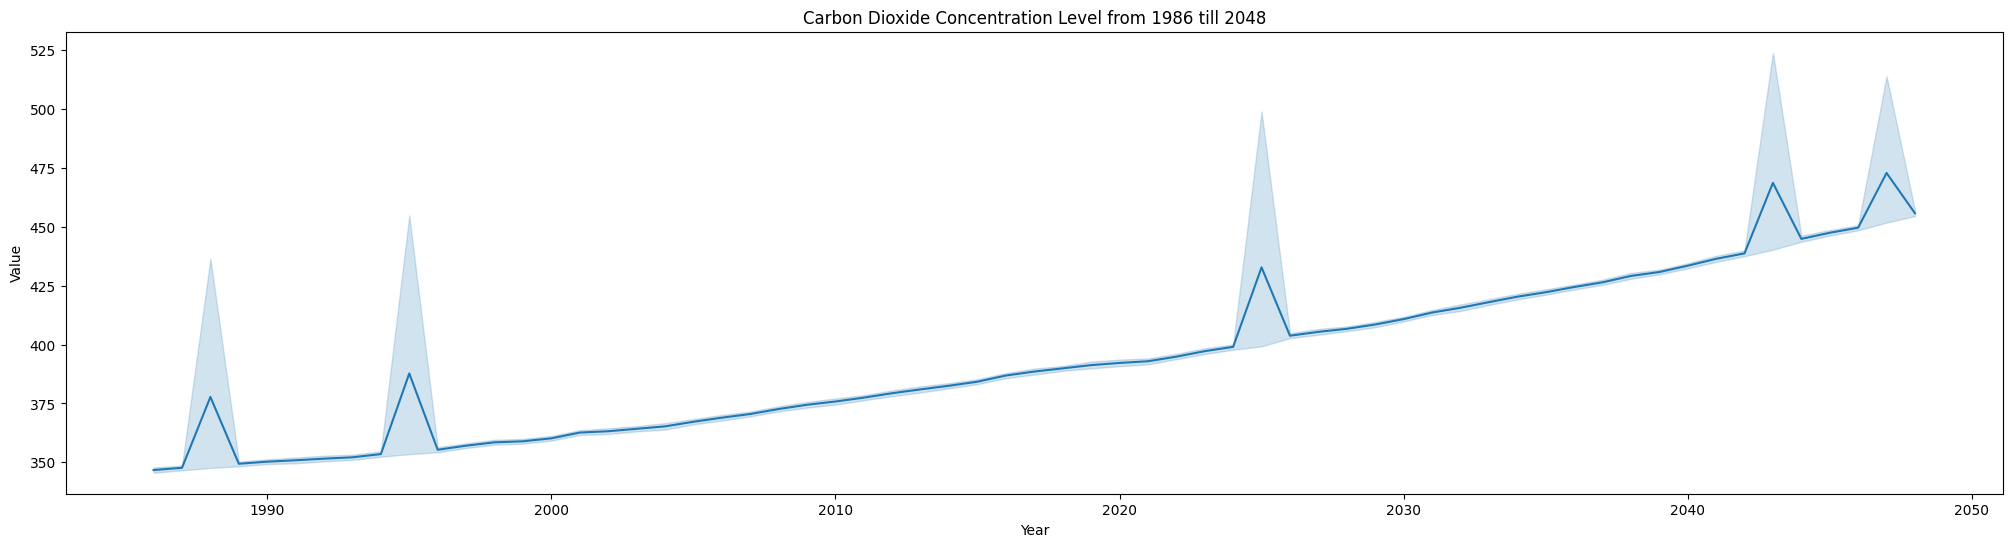

In [ ]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.lineplot(data=data, x='Year', y='Value', ax=ax)
ax.set_title('Carbon Dioxide Concentration Level from 1986 till 2048')

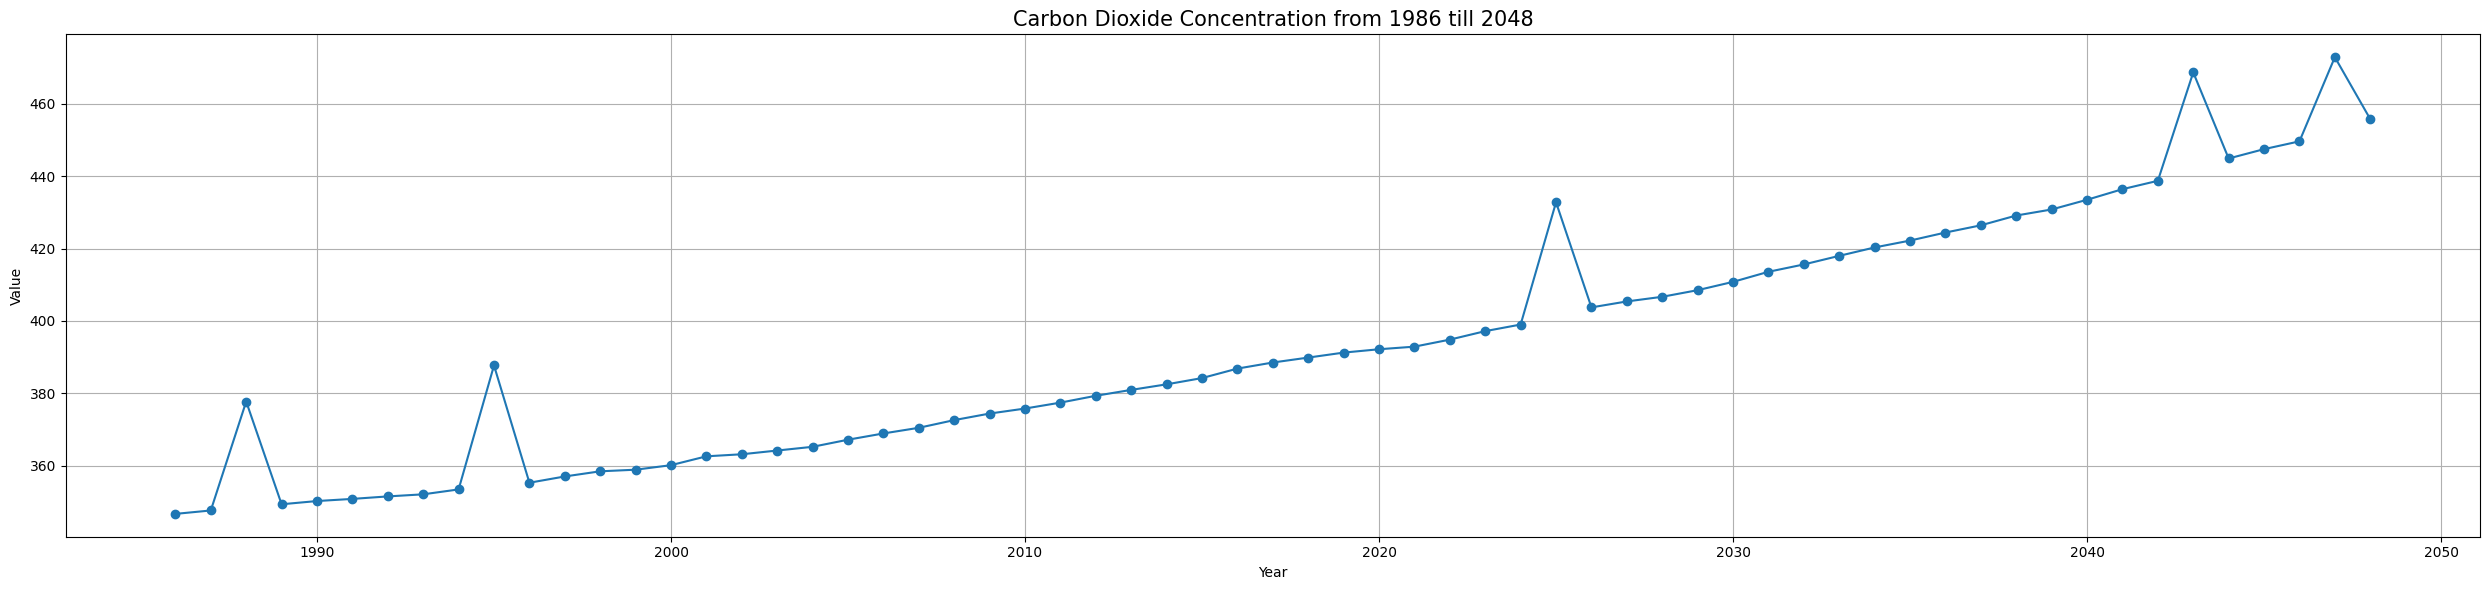

In [ ]:
fig, ax = plt.subplots(figsize=(25, 6))
yearly_data = data.groupby('Year')['Value'].mean()

# Plot 'Value' against 'Year'
plt.plot(yearly_data.index, yearly_data.values, marker='o', linestyle='-')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Carbon Dioxide Concentration from 1986 till 2048', fontsize=15)
# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

In [6]:
# Create a new DataFrame for prediction with future dates (next 24 months)
future_dates = pd.date_range(start='1/1/2048', end='31/12/2049', freq='M')
future_data = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month_name(),
})

# Convert the 'Month' column in the future_data DataFrame to categorical with the same order
future_data['Month'] = pd.Categorical(future_data['Month'], categories=month_order, ordered=True)

C:\Users\puyus\AppData\Local\Temp\ipykernel_28876\2563576481.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  future_dates = pd.date_range(start='1/1/2048', end='31/12/2049', freq='M')


# **Imputing Missing Values**

In [7]:
li = data[['Value']].copy()
si = data[['Value']].copy()

**Linear interpolation in time series refers to a method of estimating missing values or filling in gaps in a time series data by assuming a linear relationship between the available data points. It assumes that the values between the known data points change linearly over time. It is reasonable for small gaps but also captures the trend for larger gaps. However, the seasonality is lost.**

Text(0.5, 0, 'Time')

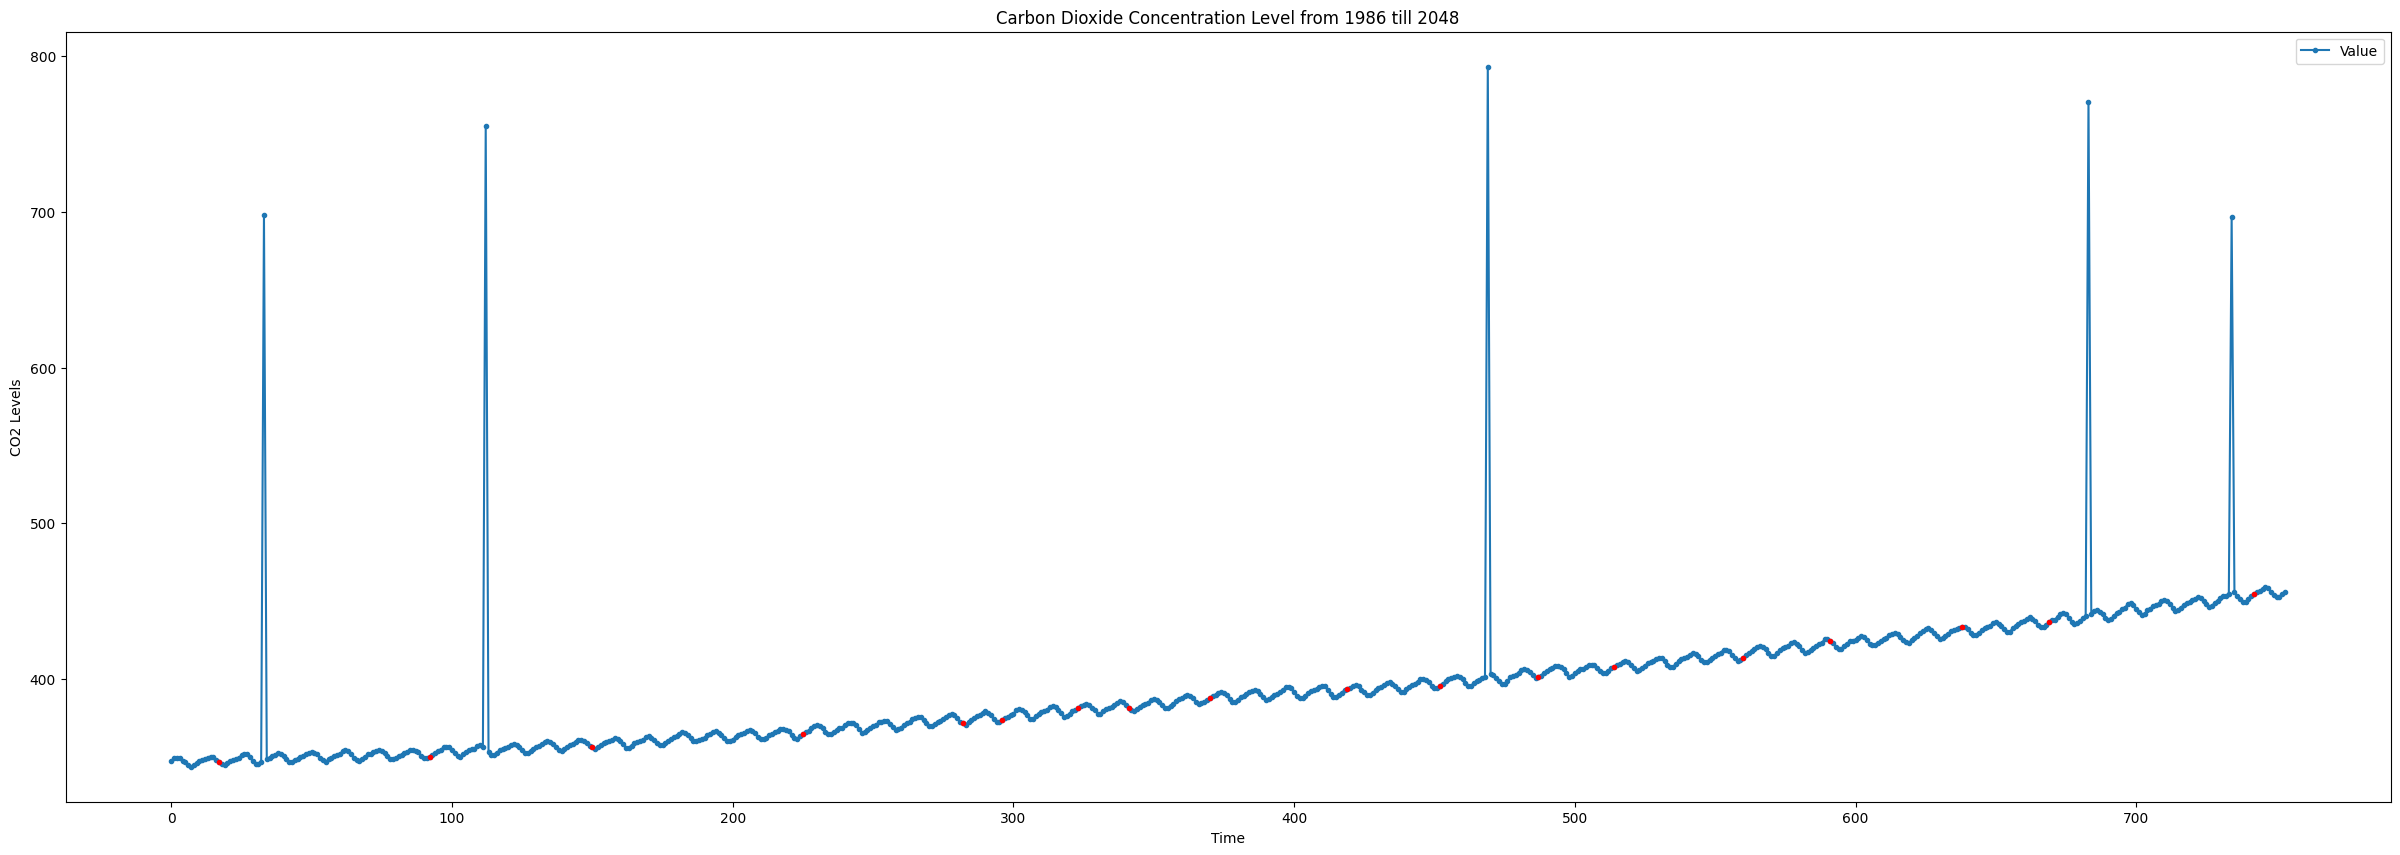

In [ ]:
li_imputed = li.interpolate(method='linear')
ax = li_imputed.plot(linestyle="-", marker=".", figsize=[30, 10])
li_imputed[li.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Carbon Dioxide Concentration Level from 1986 till 2048')
ax.set_ylabel('CO2 Levels')
ax.set_xlabel('Time')

**Spine Interpolation is used to create a smooth and continuous curve that passes through given data points. It divides the data into smaller segments and fits separate low-degree polynomials to each segment which enforces continuity at the points where spline segments join. It can capture more complex and non-linear patterns in the data, as cubic splines can represent a wider range of curves. It reduces the risk of overfitting compared to higher-degree polynomial interpolation.**

Text(0.5, 0, 'Time')

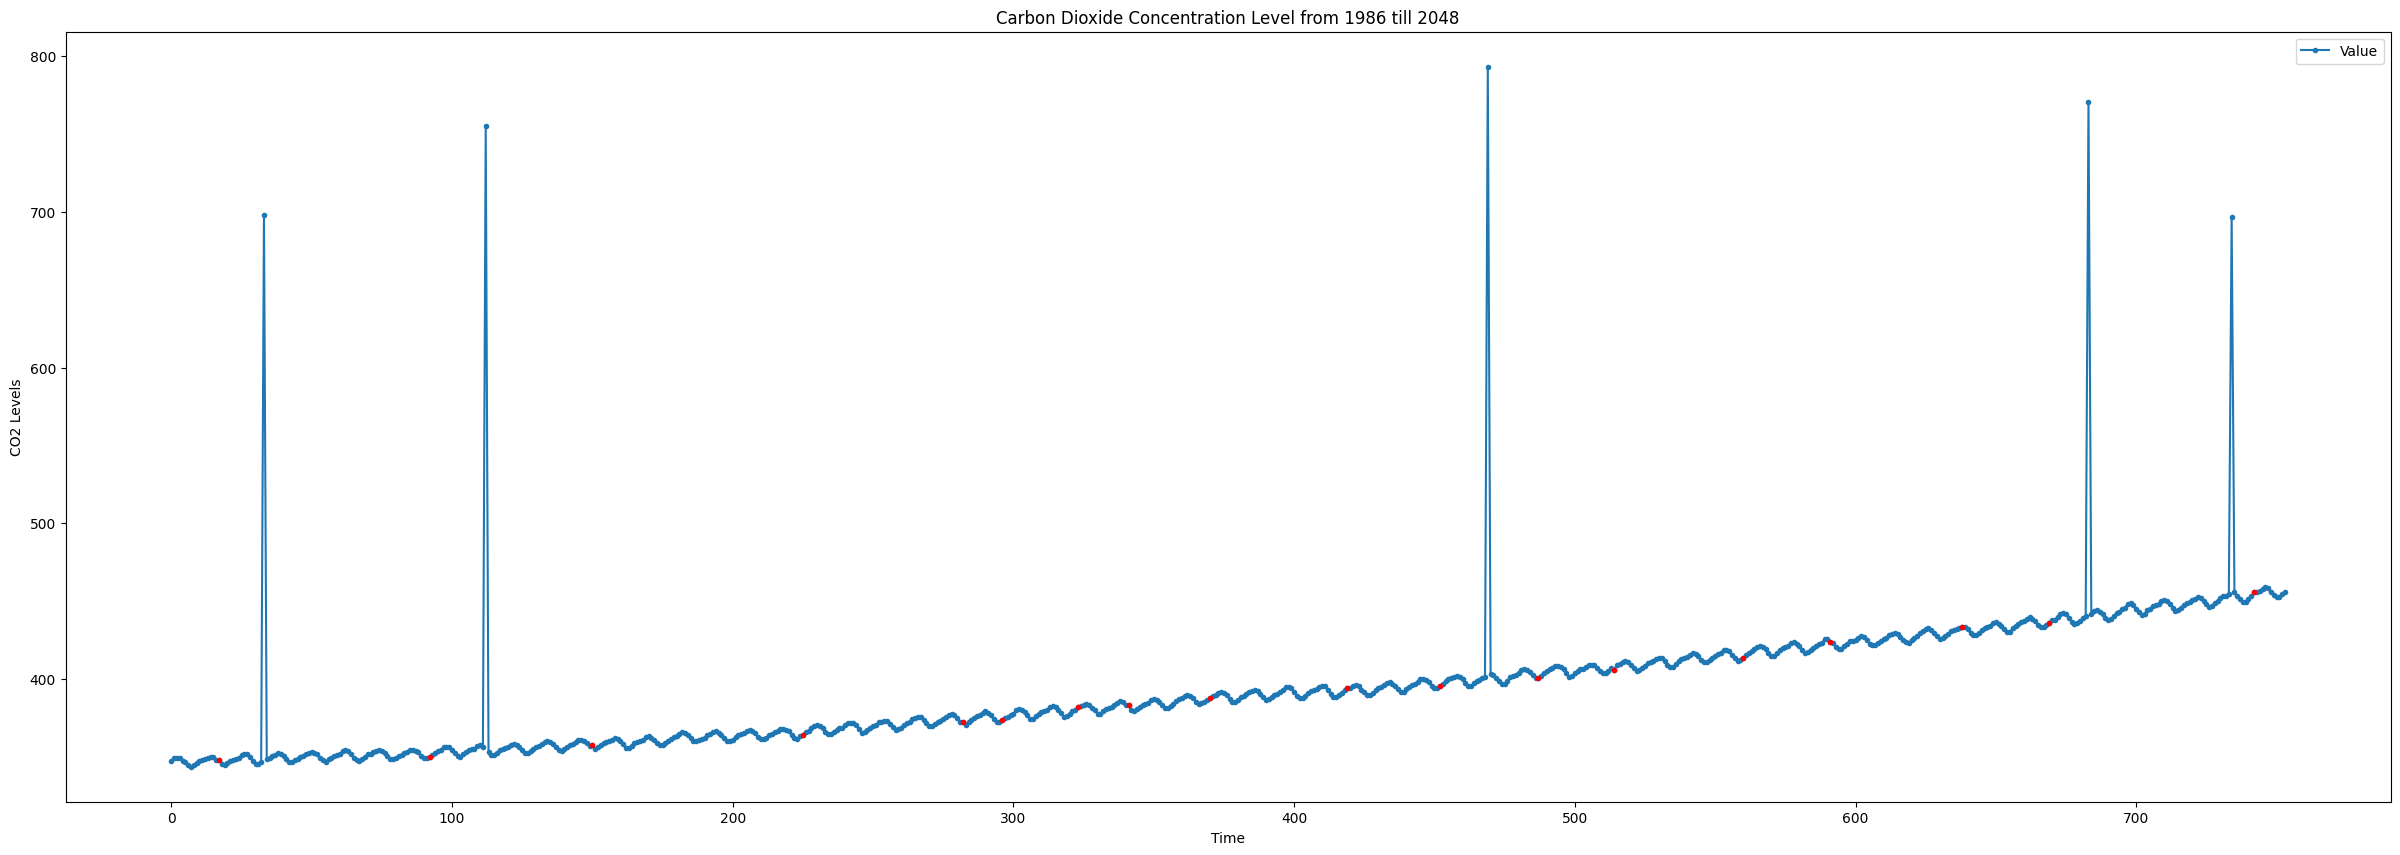

In [8]:
si_imputed = si.interpolate(method='spline', order=3)
ax = si_imputed.plot(linestyle="-", marker=".", figsize=[30, 10])
si_imputed[si.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Carbon Dioxide Concentration Level from 1986 till 2048')
ax.set_ylabel('CO2 Levels')
ax.set_xlabel('Time')

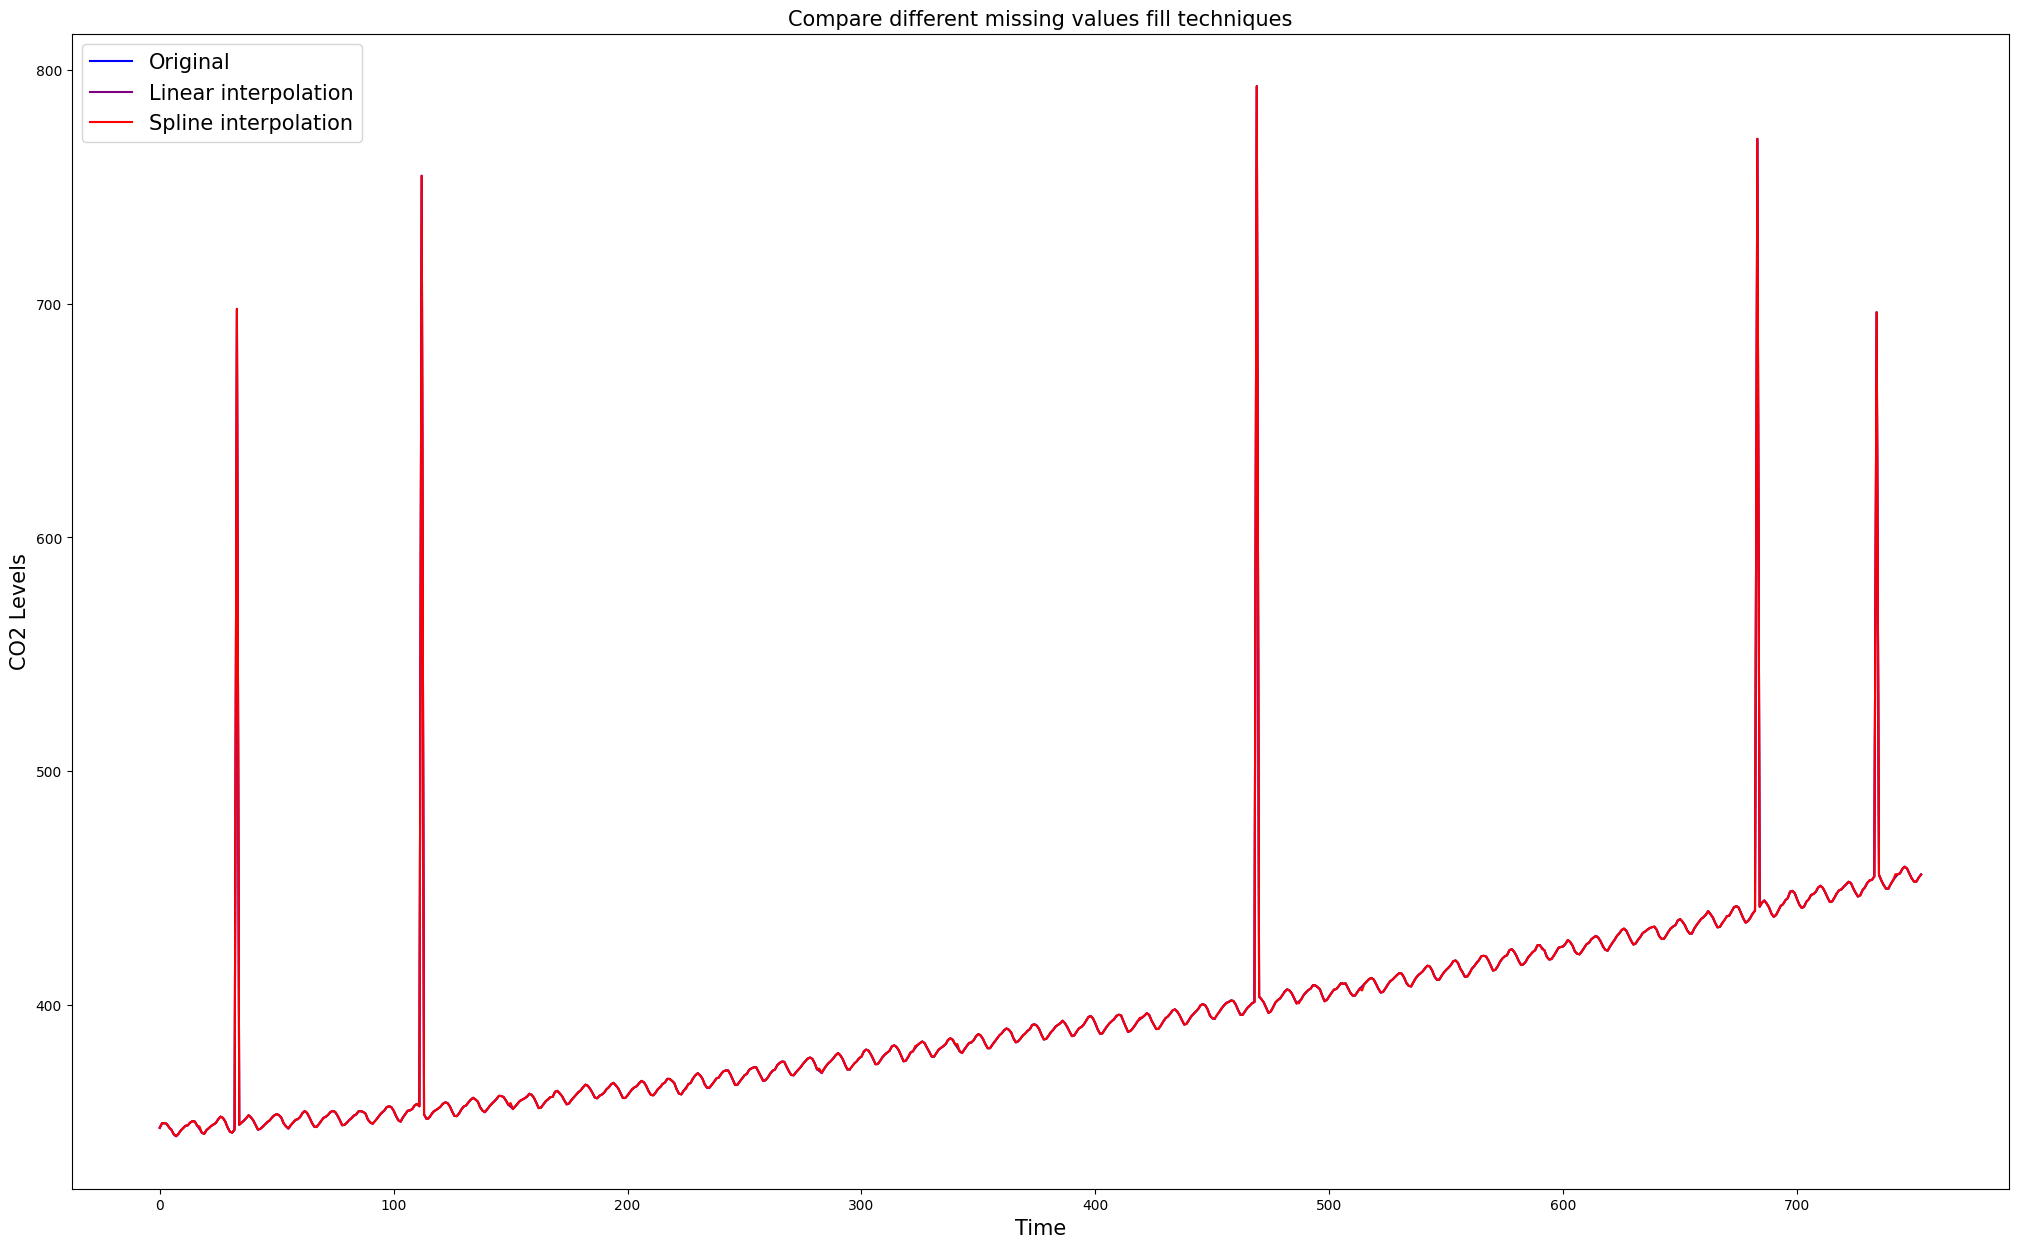

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))
data[['Value']].plot(ax=ax, color='blue', label='Original')
li_imputed.plot(ax=ax, color='purple', label='Linear interpolation')
si_imputed.plot(ax=ax, color='red', label='Spline interpolation')
plt.xlabel('Time', fontsize=15)
plt.ylabel('CO2 Levels', fontsize=15)
plt.title('Compare different missing values fill techniques', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)
ax.legend(['Original', 'Linear interpolation', 'Spline interpolation'], fontsize=15);
plt.show()

In [9]:
# Going with Spine Interpolation
df = si_imputed.copy()
data['Value'] = df['Value']

# **Handling Outliers**

**To not influence the results of our analysis or modeling, We identified Outliers using ‘Isolation Forest’. Here, outliers are isolated from the majority of the data. It creates a collection of isolation trees, where each tree is constructed using a random subset of the data points. To identify outliers, the algorithm measures the average path length it takes to isolate a data point.  Anomalies are expected to have shorter path lengths because they are isolated more quickly due to their distinctiveness.  It assigns a score to each data point based on the average path length. Lower path lengths correspond to higher anomaly scores. Now, replace outliers with the corresponding value from the moving average. This smooths the data and removes extreme fluctuations. The moving average is computed by taking the average of a fixed number of data points within a moving window. This window moves sequentially through the data, one step at a time, providing a series of average values.**

**SMA(t) = (X(t) + X(t-1) + X(t-2) + ... + X(t-n)) / n, where X(t) is the data point at time t, and n is the window size.**

In [10]:
def run_isolation_forest(model_data: pd.DataFrame, contamination=0.006, n_estimators=200, max_samples=0.7) -> pd.DataFrame:

    IF = (IsolationForest(random_state=0,
                          contamination=contamination,
                          n_estimators=n_estimators,
                          max_samples=max_samples)
         )

    IF.fit(model_data)

    output = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)
    score = IF.decision_function(model_data)

    return output, score

outliers, score = run_isolation_forest(data[['Value']])
df = (df.assign(Outliers = outliers).assign(Score = score))

c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
df[df['Outliers'] == 1]

,Value,Outliers,Score
33,697.81,1,-0.080784
112,754.79,1,-0.088677
469,793.13,1,-0.109754
683,770.61,1,-0.091407
734,696.35,1,-0.081275


In [11]:
def outliers(thresh):
    print(f'Number of Outliers below Anomaly Score Threshold {thresh}:')
    print(len(df.query(f"Outliers == 1 & Score <= {thresh}")))

# Function to view number of outliers at a given threshold
anomaly_threshold = 0.05
outliers(anomaly_threshold)

Number of Outliers below Anomaly Score Threshold 0.05:
5


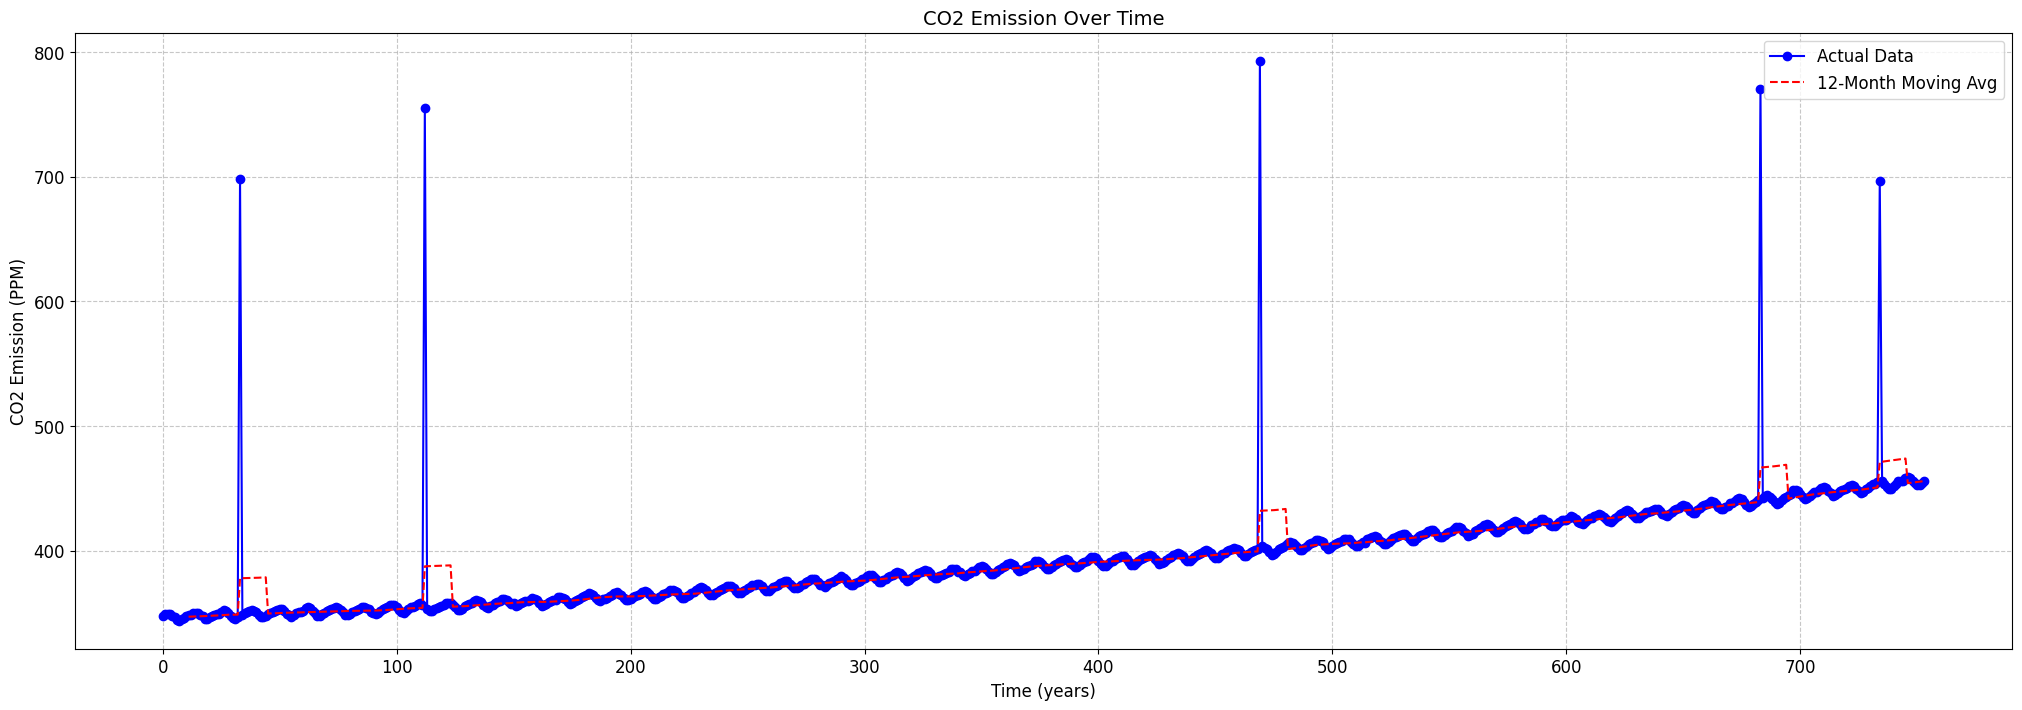

In [12]:
window_size = 12  # Adjust the window size as needed
moving_avg = pd.DataFrame()
moving_avg['Value'] = data['Value'].rolling(window_size).mean()
plt.figure(figsize=(25, 8))
# Plot the data and moving average with customized line styles and colors
plt.plot(data['Value'], label='Actual Data', linestyle='-', marker='o', color='blue')
plt.plot(moving_avg['Value'], label=f'{window_size}-Month Moving Avg', linestyle='--', color='red')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('CO2 Emission (PPM)', fontsize=12)
plt.title('CO2 Emission Over Time', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [13]:
# Identify anomalies and replace with rolling mean
anomalies = df['Score'] < anomaly_threshold

# Replace anomalies with rolling mean
df.loc[anomalies, 'Value'] = moving_avg[anomalies]
data['Value'] = df['Value']

# Print the modified DataFrame
df.head(10)

,Value,Outliers,Score
0,347.27,0,0.230397
1,349.20,0,0.270418
2,349.26,0,0.272484
3,348.96,0,0.258490
4,347.45,0,0.238876
5,346.42,0,0.211785
6,344.52,0,0.127830
7,343.67,0,0.075708
8,344.66,0,0.141291
9,346.14,0,0.181306


# **Time Series Decomposition**

**The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.**

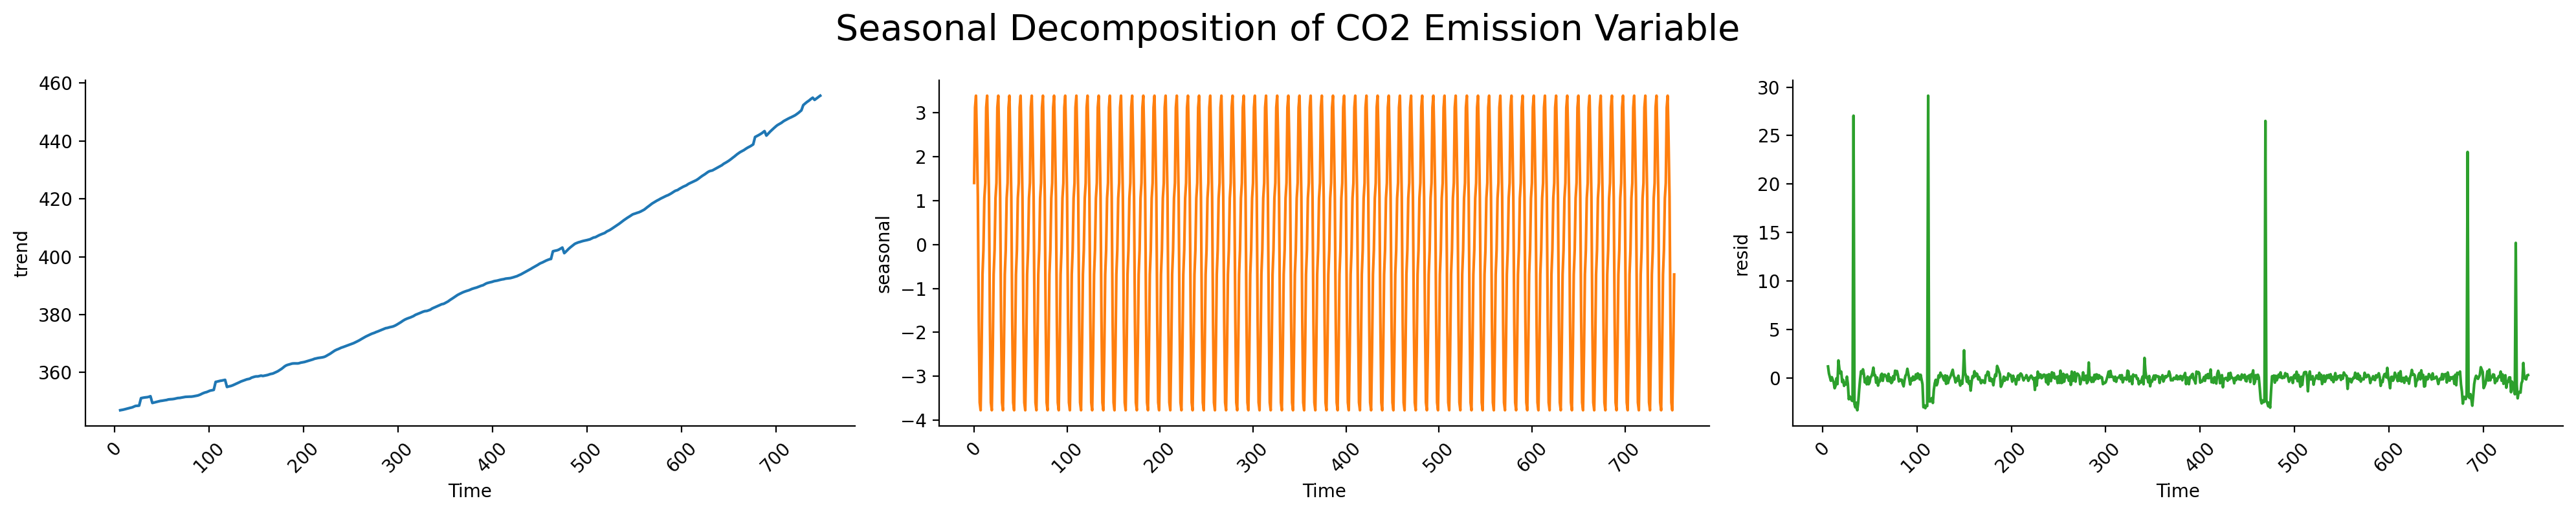

In [ ]:
colors = plt.rcParams["axes.prop_cycle"]()
results = seasonal_decompose(data['Value'], period=12)
trend = results.trend
seasonal = results.seasonal
residual = results.resid
properties = [trend, seasonal, residual]
a = 1  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(20,4), dpi=200)
fig.suptitle(f'Seasonal Decomposition of CO2 Emission Variable', fontsize=20)
for i in properties:
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    plt.plot(i , color=color)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel('Time')
    plt.ylabel(i.name)
    plt.xticks(rotation=45)
    c = c+1
plt.tight_layout()
plt.show()

**Linear Trend (T(t)): The linear trend component represents a consistent, long-term increase in the data over time. This means that, when you examine the data as a whole, there is a clear, linear pattern in how it changes.**

**Seasonal Variation (S(t)): The seasonal component refers to repetitive, periodic patterns in the data that occur at fixed intervals. Seasonality implies that the data experiences similar fluctuations at the same points in each season.**

**Constant Residual Component (C): The residual component represents the part of the data that remains after removing the linear trend and seasonal effects.**

**Y(t)=T(t)+S(t)+C where Y(t) is the observed value at time t.**

# **Predictive Modelling**

# **ARIMA Model**

**Stationary time series data has statistical properties that remain constant over time. This means that the mean, variance, and other statistical moments of the data series do not change with time. Stationary data often exhibits more interpretable and predictable patterns. Forecasting models perform better on stationary data because they can more effectively capture the underlying patterns and relationships in the data without the distraction of changing statistical properties.**

**Find p, d, q of ARIMA Model**

In [ ]:
# To check the stationarity, we performed an Augmented Dickey-Fuller (ADF) test.
# The null hypothesis states that the data has a stochastic trend or is non-stationary,
# while the alternative hypothesis suggests that the time series data is stationary. The Test involves regressing the first differencing
# (helps to remove the trend component from the series) of the time series data on its lagged values.

d = 0
p_value = adfuller(data['Value'])[1]
diff_data = data['Value']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1

print(f'P Value: {p_value}\t Number of differencing needed: {d}')

P Value: 0.0	 Number of differencing needed: 1


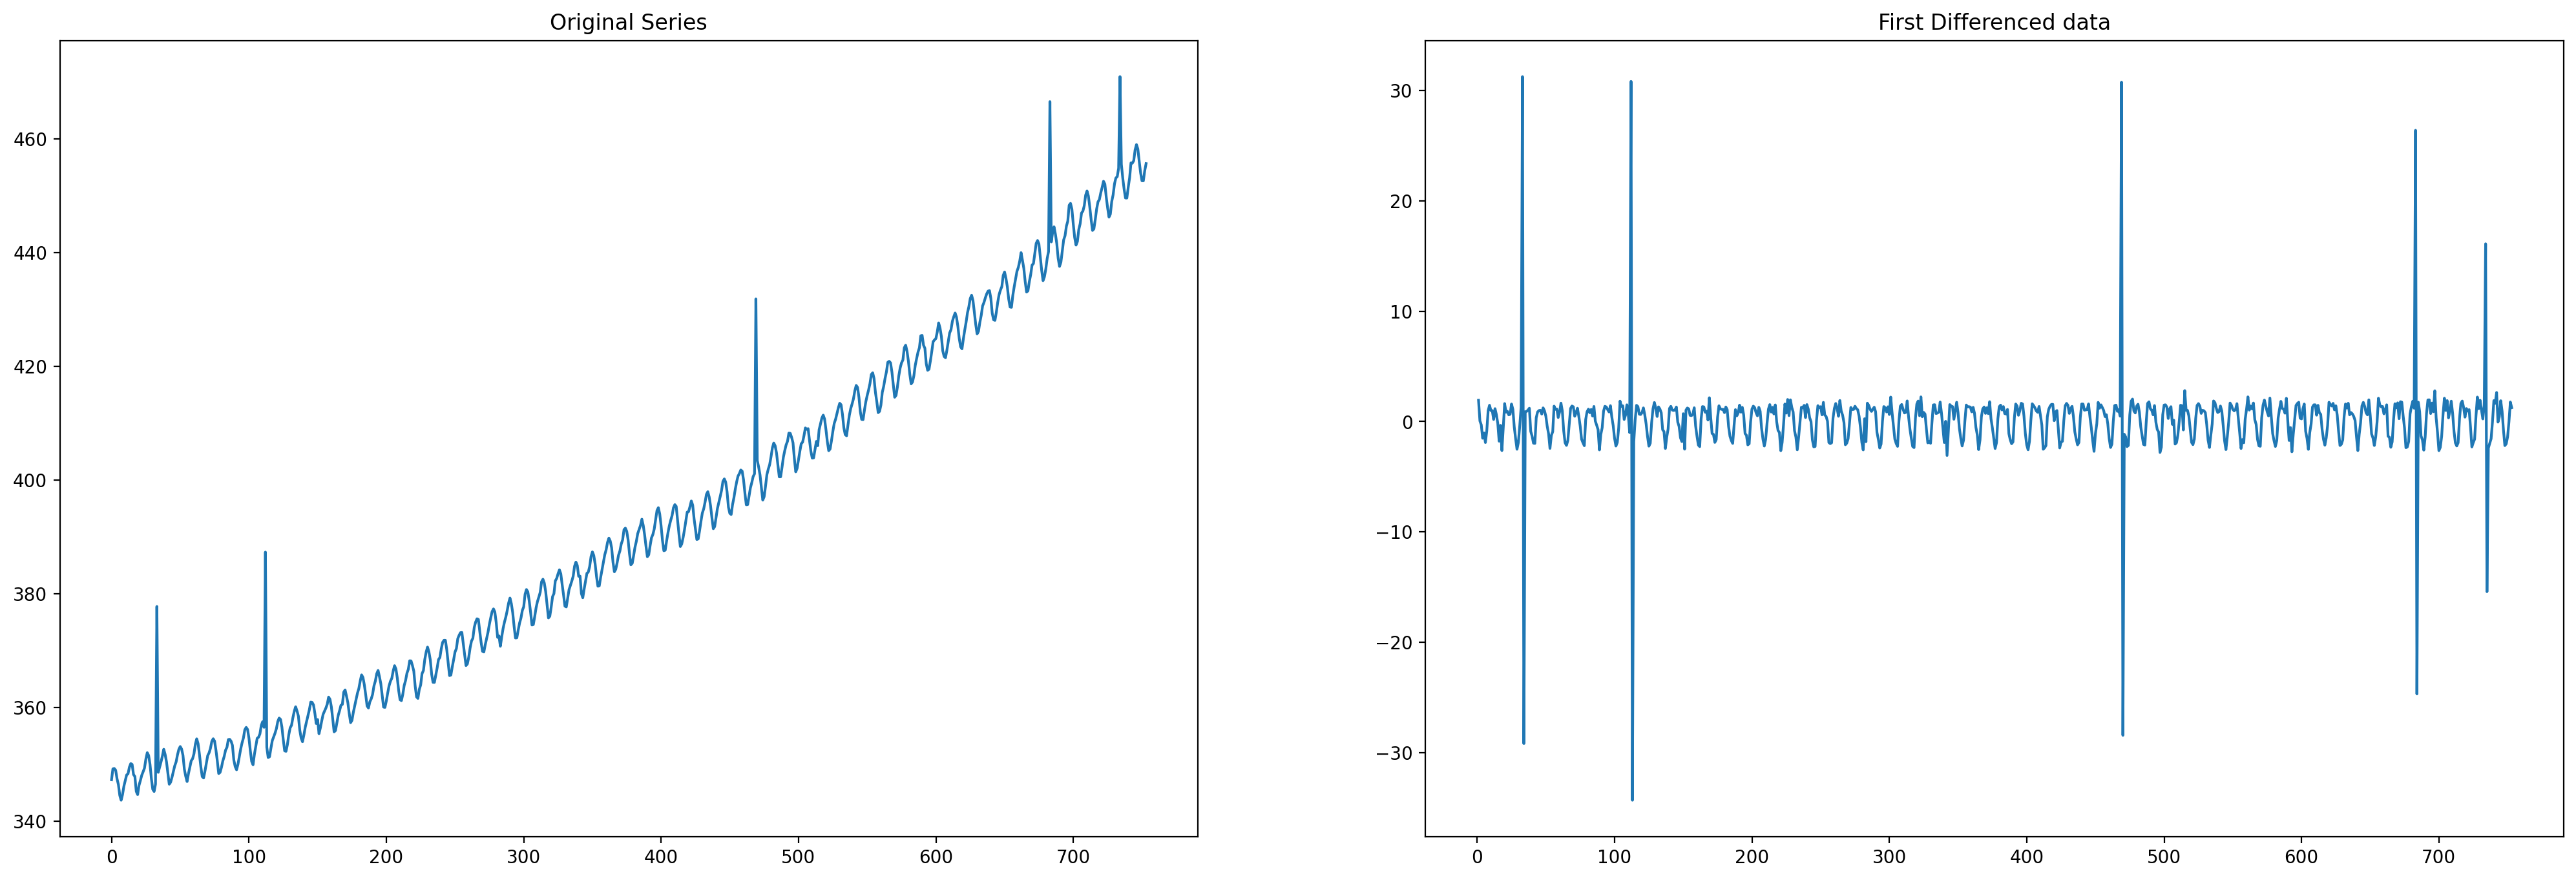

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharex=True)
axes[0].plot(data['Value']); axes[0].set_title('Original Series')
axes[1].plot(diff_data); axes[1].set_title('First Differenced data')
fig.set_dpi(200)
plt.show()

**We can see that data look stationary now, as values are equally distributed around zero. Now the data is ready to be used in any statistical model. So, d = 1**

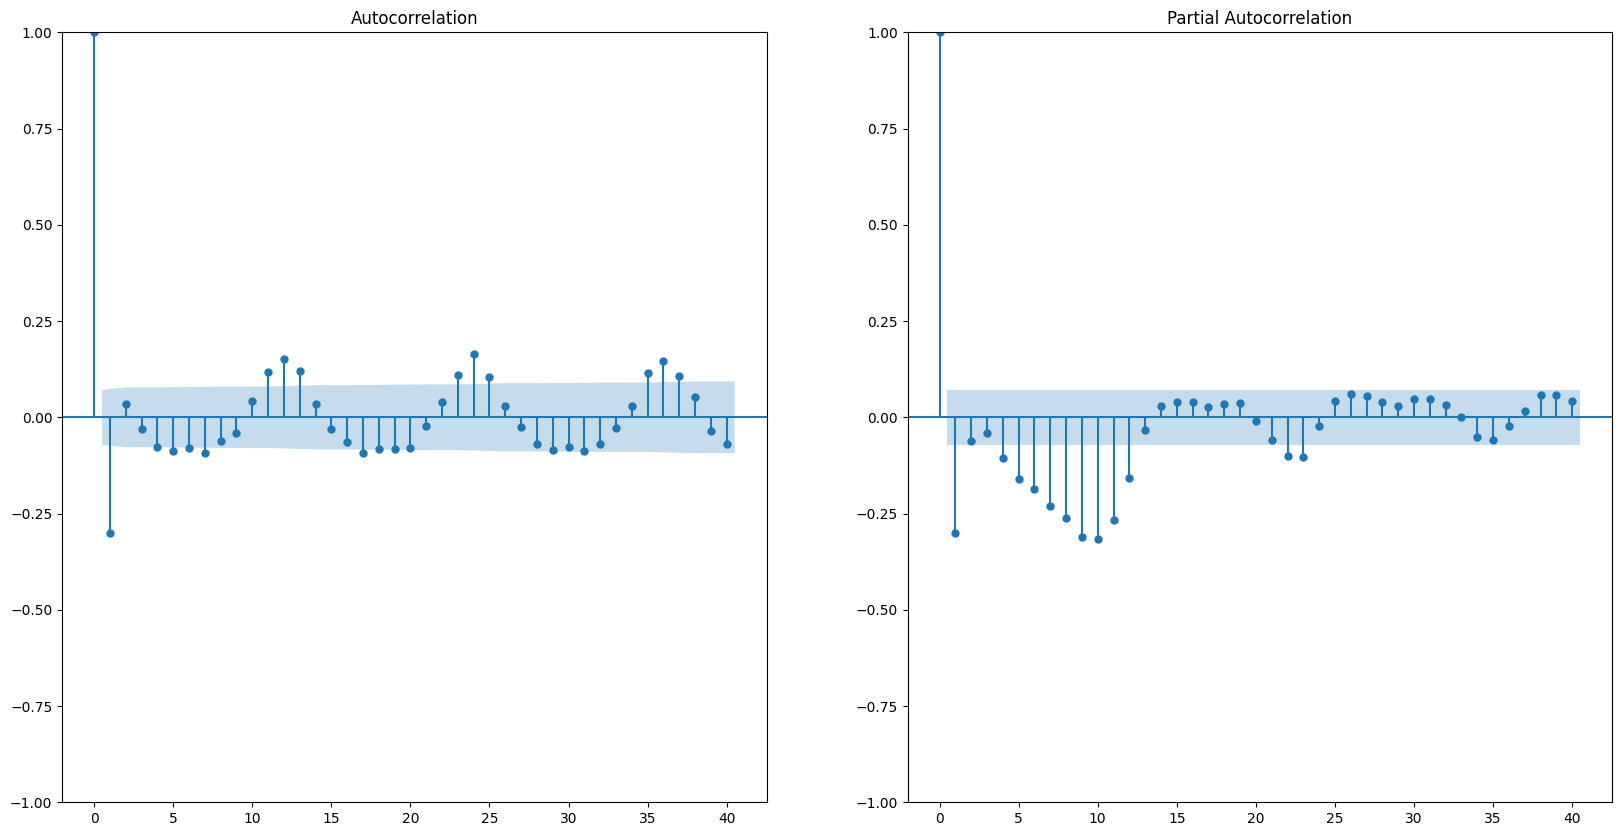

In [ ]:
# Partial Autocorrelation, is the correlation between current value and a particular value in past, ignoring all values in between.
# We can use PACF graph to find the last significat lag that is above the threshold area.

# Autocorrelation, is tells the number MA that should be removed so that there is no autocorrelation in the stationarized series.
# Number of lags outside the threshold area is the, value of MR (q).
fig, (ax1,ax2) = plt.subplots(figsize = (20,10), ncols = 2)
plot_acf(diff_data.dropna(), ax = ax1, lags = 40)
plot_pacf(diff_data.dropna(), ax = ax2, lags = 40)
plt.show()

**Last significat lag is 11, so value of p = 11**

**The correlogram shows a damped cosine shape. Potential values for q is 1, 11, 12, 13**

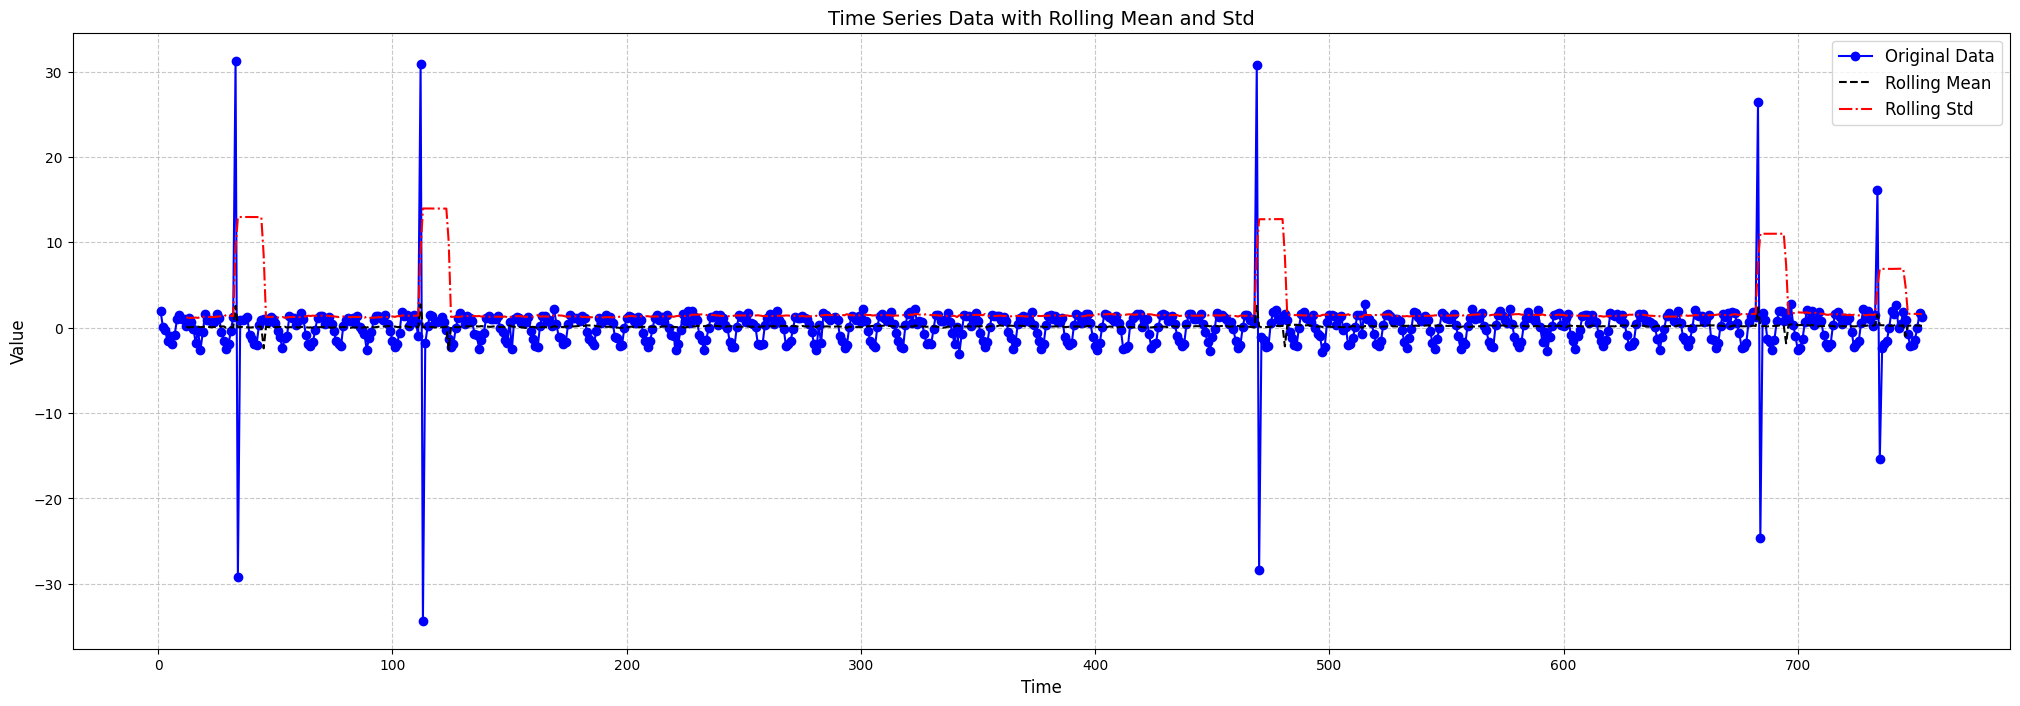

In [ ]:
def plot_graph(timeseries):
    rolling_avg = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    plt.figure(figsize=(25, 8))
    # Plot the original data, rolling mean, and rolling standard deviation with customized line styles and colors
    original_data = plt.plot(timeseries, label="Original Data", linestyle='-', marker='o', color='blue')
    mean = plt.plot(rolling_avg, label="Rolling Mean", linestyle='--', color='black')
    std = plt.plot(rolling_std, label="Rolling Std", linestyle='-.', color='red')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(loc="best", fontsize=12)
    plt.title("Time Series Data with Rolling Mean and Std", fontsize=14)
    plt.show()

plot_graph(diff_data.dropna())

**It can be seen that the Rolling Average is constant. Standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both remain time invariant or constant**

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
from math import sqrt
from sklearn.metrics import mean_squared_error
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
training_proportion = 0.90

# We can calculate how many samples correspond to that proportion
n_obs = data.shape[0]
n_train = int(n_obs * training_proportion)

# Training set
train = data[['Value']].iloc[:n_train]
# Testing set
test = data[['Value']].iloc[n_train:]

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 15)
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=60.402
ARIMA(0, 0, 1) RMSE=32.757
ARIMA(0, 0, 2) RMSE=21.235
ARIMA(0, 0, 3) RMSE=15.805
ARIMA(0, 0, 4) RMSE=12.735
ARIMA(0, 0, 5) RMSE=10.908
ARIMA(0, 0, 6) RMSE=9.595
ARIMA(0, 0, 7) RMSE=8.847
ARIMA(0, 0, 8) RMSE=8.335
ARIMA(0, 0, 9) RMSE=8.796
ARIMA(0, 0, 10) RMSE=8.095
ARIMA(0, 1, 0) RMSE=5.101
ARIMA(0, 1, 1) RMSE=4.764
ARIMA(0, 1, 2) RMSE=4.841
ARIMA(0, 1, 3) RMSE=4.579
ARIMA(0, 1, 4) RMSE=4.540
ARIMA(0, 1, 5) RMSE=4.536
ARIMA(0, 1, 6) RMSE=4.560
ARIMA(0, 1, 7) RMSE=4.404
ARIMA(0, 1, 8) RMSE=4.320
ARIMA(0, 1, 9) RMSE=4.285
ARIMA(0, 1, 10) RMSE=4.229
ARIMA(0, 2, 0) RMSE=8.456
ARIMA(0, 2, 1) RMSE=5.100
ARIMA(0, 2, 2) RMSE=4.757
ARIMA(0, 2, 3) RMSE=4.358
ARIMA(0, 2, 4) RMSE=4.292
ARIMA(0, 2, 5) RMSE=4.371
ARIMA(0, 2, 6) RMSE=4.268
ARIMA(0, 2, 7) RMSE=4.260
ARIMA(0, 2, 8) RMSE=4.158
ARIMA(0, 2, 9) RMSE=4.114
ARIMA(0, 2, 10) RMSE=4.098
ARIMA(1, 0, 0) RMSE=5.123
ARIMA(1, 0, 1) RMSE=4.774
ARIMA(1, 0, 2) RMSE=4.839
ARIMA(1, 0, 3) RMSE=4.584
ARIMA(1, 0, 4) RMSE=4.545
ARI

**ARIMA RMSE: 3.685**

In [ ]:
# From Auto-Correlation and Partial-Correlation Graphs, we have chosen the p, d, q values
train = data['Value']
p, d, q = 11, 1, 16
fcst = []

for _ in range(24):
    arima = ARIMA(train, order=(p, d, q))
    arima_final = arima.fit()
    prediction = arima_final.forecast(steps=1)
    fcst.append(np.array(prediction)[0])

    # Append the prediction to the 'train' series
    train = train.append(pd.Series(np.array(prediction)[0], index=[train.index[-1] + 1]))

In [ ]:
future_data = pd.DataFrame()
future_data['Predicted_Value'] = fcst

# 'fcst' now contains the 24-step ahead forecasts
print("Forecasts for the next 24 steps:")
print(fcst)

Forecasts for the next 24 steps:
[457.46043734347086, 459.36859445791845, 460.9150343419736, 461.7259556688219, 461.53515344622184, 460.0549556166071, 458.3594032869461, 457.02949898448026, 456.08818847388744, 455.48727929503514, 456.29776887737955, 457.863070602175, 459.7700180557128, 461.89778314485295, 463.3379949462568, 463.83101955754296, 463.52062309245053, 462.3615062186888, 460.82028288595967, 459.0692893453022, 458.1250286912503, 457.80886882230135, 458.52882733422547, 460.0565815835341]


In [ ]:
# Plot the backtest (actual vs. forecast)
def plot_backtest(actual, forecast, model_name):
    plt.figure(figsize=(25, 6))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(range(len(actual), len(actual) + len(forecast)), forecast, label='Forecast', marker='o')
    plt.title(f'{model_name} Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

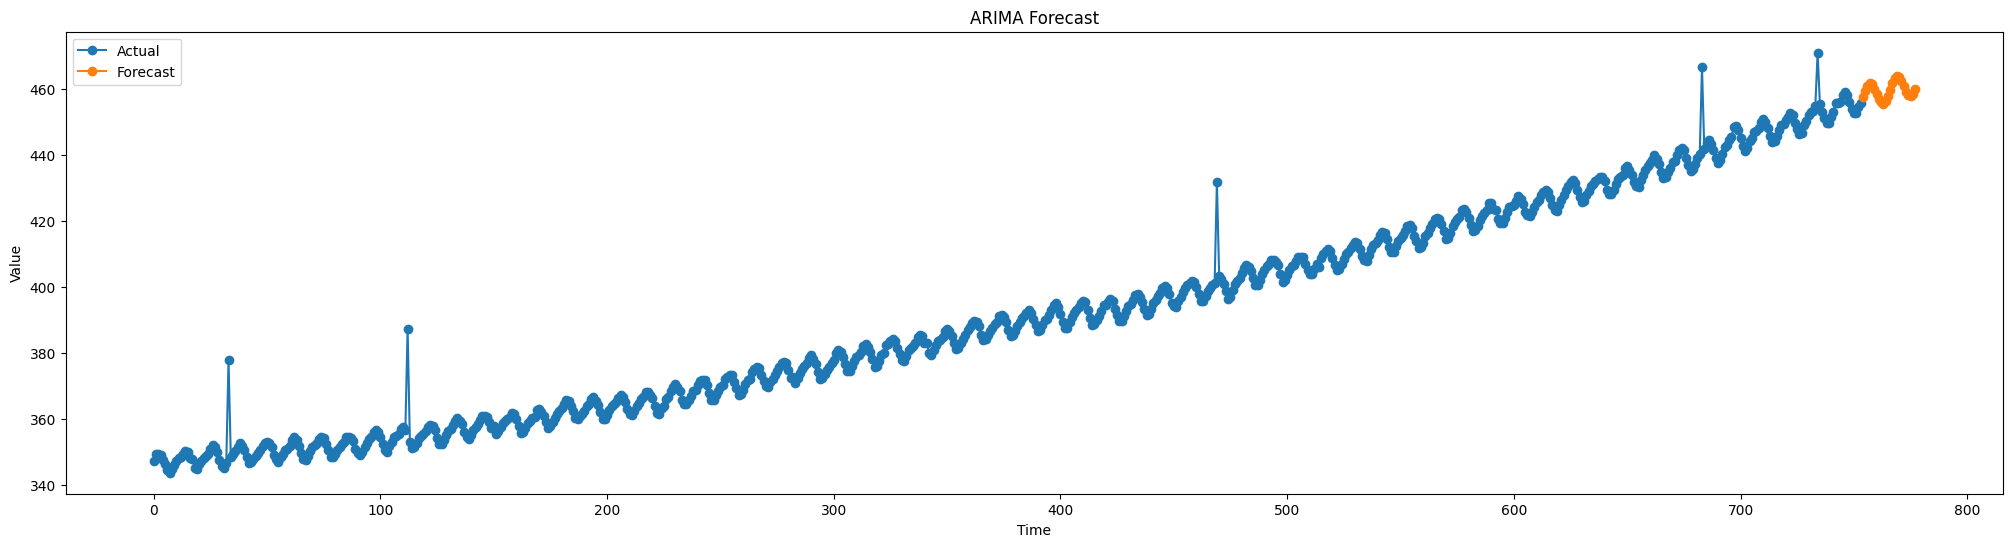

In [ ]:
model_name = 'ARIMA'
plot_backtest(data['Value'], future_data['Predicted_Value'], model_name)

In [ ]:
# From the function, the p, d, q we got
model = ARIMA(data['Value'].values, order=(3,1,8))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  754
Model:                 ARIMA(3, 1, 8)   Log Likelihood               -1746.465
Date:                Fri, 27 Oct 2023   AIC                           3516.930
Time:                        12:17:38   BIC                           3572.419
Sample:                             0   HQIC                          3538.307
                                - 754                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7134      0.015    179.287      0.000       2.684       2.743
ar.L2         -2.7001      0.026   -103.156      0.000      -2.751      -2.649
ar.L3          0.9820      0.015     64.695      0.0

c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


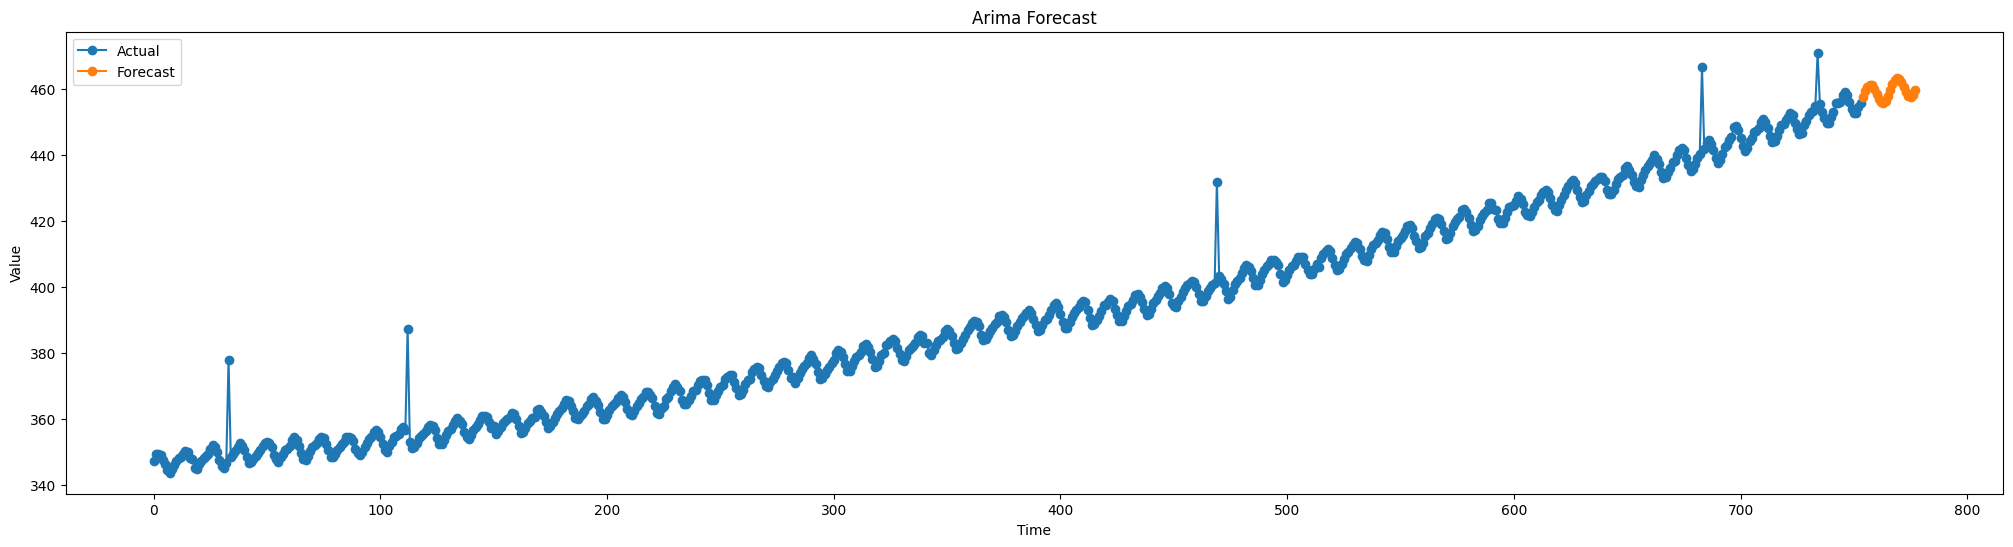

In [ ]:
# Define the number of steps to forecast
forecast_steps = 24
model_name = 'Arima'
# Forecast future values
forecast = model.forecast(steps=forecast_steps)
future_data['Predicted_Value'] = forecast

plot_backtest(data['Value'], future_data['Predicted_Value'], model_name)

# **Triple Exponential Smoothing**

**📌 Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series. This method is sometimes called Holt-Winters Exponential Smoothing**

**1. Alpha, also called the smoothing factor controls the rate at which the influence of the observations at prior time steps decay exponentially. It is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.**

**2. Beta controls the decay of the influence of the change in trend.**

**3. Gamma that controls the influence on the seasonal component. As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.**

In [14]:
training_proportion = 0.95
n_obs = data.shape[0]
n_train = int(n_obs * training_proportion)
# Training set
train = data[['Value']].iloc[:n_train]
# Testing set
test = data[['Value']].iloc[n_train:]

In [15]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train["Value"].plot(figsize=(20, 6), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test["Value"].plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

def tes_optimizer(train, abg, trend, seasonal,  seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

def tes_model_tuning(train, test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
    alphas = betas = gammas = np.arange(0.10, 1, 0.10)
    abg = list(itertools.product(alphas, betas, gammas))
    best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg=abg, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, step=step)
    final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)
    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    plot_model(train, test, y_pred, title)
    return best_alpha, best_beta, best_gamma, best_mae

c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retval

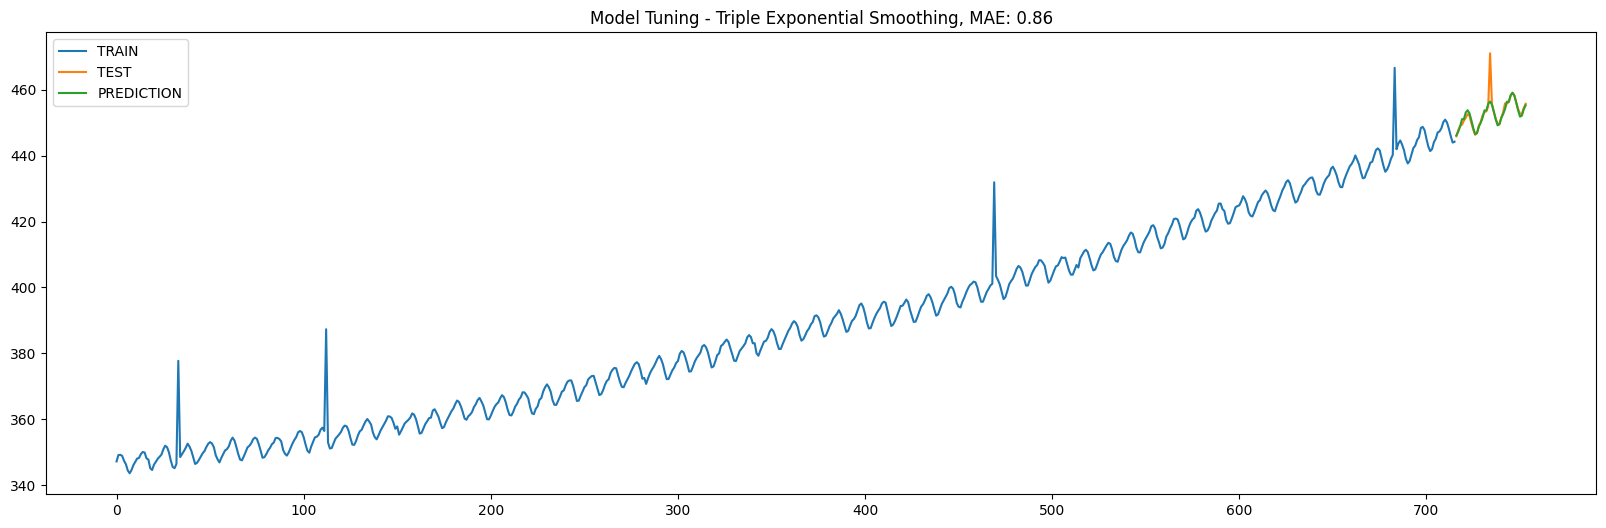

In [16]:
best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, test, step=len(test), trend='add', seasonal='add', seasonal_periods=12)

In [17]:
best_mae

0.8631254323983446

**Triple Exponential Smoothing MAE: 0.86**

In [ ]:
def tes_final_model(y, best_alpha, best_beta, best_gamma, step, trend='add', seasonal='add', seasonal_period=12):
  final_model = ExponentialSmoothing(y, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
  feature_predict = final_model.forecast(step)
  return feature_predict

exp_smoothing_preds = tes_final_model(data['Value'].values, best_alpha, best_beta, best_gamma, step=24)

C:\Users\puyus\AppData\Local\Temp\ipykernel_13692\3874270212.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  final_model = ExponentialSmoothing(y, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)


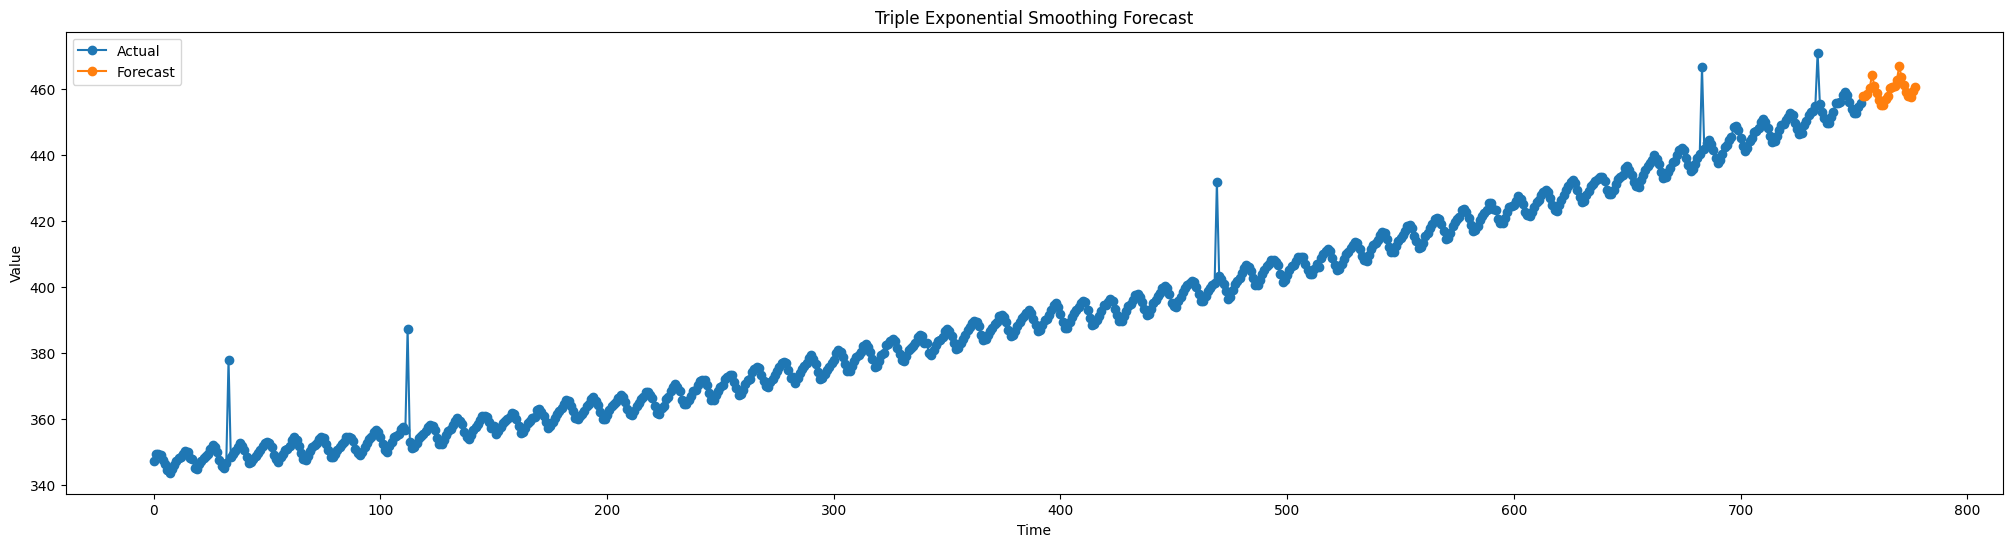

In [ ]:
future_data['Predicted_Value'] = exp_smoothing_preds

model_name = 'Triple Exponential Smoothing'

plot_backtest(data['Value'], future_data['Predicted_Value'], model_name)

# **SARIMAX**

**Seasonal Autoregressive Integrated Moving Averages are designed to handle time series data with both non-seasonal and seasonal patterns, making them particularly useful for forecasting when there are recurring patterns over fixed time intervals. It incorporates a seasonal component to capture the periodic patterns in the data. The seasonal component helps model the repeating patterns observed in the data, such as monthly sales trends or quarterly financial reports. It also includes the non-seasonal part, which is essentially an ARIMA model. This component captures the non-seasonal trends, autoregressive (AR) behavior, and moving average (MA) behavior in the data. The non-seasonal component helps account for any long-term trends and serial correlation in the data.**

In [ ]:
import pmdarima as pm

model = pm.auto_arima(data['Value'], trace=True, seasonal=True, suppress_warnings=True, m=12, error_action='ignore', maxiter=10)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3589.966, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4000.961, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3872.983, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3865.186, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4000.280, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3764.742, Time=0.41 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3717.941, Time=0.41 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3580.775, Time=1.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=3642.125, Time=0.85 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=3530.327, Time=1.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3615.303, Time=1.04 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=3530.137, Time=1.21 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=3634.148, Time=1.07 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=3610.824, Time=0.80 sec
 ARIMA(1,1,2)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  754
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -1733.594
Date:                                 Fri, 27 Oct 2023   AIC                           3479.189
Time:                                         12:33:35   BIC                           3506.933
Sample:                                              0   HQIC                          3489.877
                                                 - 754                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9275      0.023    -40.945      0.000      -0.972      -0.883
ar.S.L12       0.1042      0.183      0.569      0.569      -0.254       0.463
ar.S.L24       0.8862      0.191      4.647      0.000       0.512       1.260
ma.S.L12       0.0024      0.168      0.014      0.989      -0.327       0.332
ma.S.L24      -0.7730      0.190     -4.058      0.000      -1.146      -0.400
sigma2         5.6676      0.072     78.353      0.000       5.526       5.809
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            420812.06
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             9.51
Prob(H) (two-sided):                  0.00   Kurtosis:                       117.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
training_proportion = 0.90
n_obs = data.shape[0]
n_train = int(n_obs * training_proportion)

# Training set
train = data[['Value']].iloc[:n_train]
# Testing set
test = data[['Value']].iloc[n_train:]

In [19]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train["Value"].plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test["Value"].plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

def sarima_optimizer_mae(train, pdq, seasonal_pdq, step):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model_results = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                y_pred_test = sarimax_model_results.get_forecast(step)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
            except:
                continue
    return best_order, best_seasonal_order, best_mae

def sarima_model_tuning_mae(train, test, step, title="Model Tuning - Seasonal Autoregressive Integrated Moving-Average"):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  best_order, best_seasonal_order, best_mae = sarima_optimizer_mae(train, pdq, seasonal_pdq, step)
  final_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order).fit()
  y_pred_test = final_model.get_forecast(step)
  y_pred = y_pred_test.predicted_mean
  plot_model(train, test, y_pred, title)
  return best_order, best_seasonal_order, best_mae

c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros a

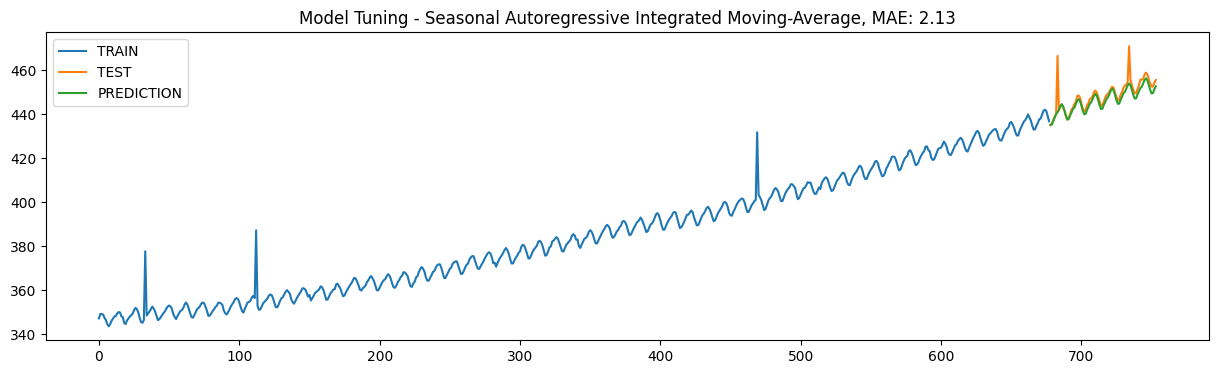

In [20]:
best_order, best_seasonal_order, best_mae = sarima_model_tuning_mae(train, test, step= len(test))

In [21]:
best_mae

2.127227187380576

In [ ]:
best_order,best_seasonal_order

((0, 1, 1), (1, 1, 0, 12))

**SARIMAX MAE: 2.12**

In [ ]:
# Selecting values from the function we defined
sarimax_model = SARIMAX(data['Value'], order=best_order, seasonal_order=best_seasonal_order).fit()
y_pred = sarimax_model.get_forecast(24)
sarima_preds = y_pred.predicted_mean.values
future_data['Predicted_Value'] = y_pred.predicted_mean.values

In [ ]:
# Selecting values we got from auto_arima
sarimax_model = SARIMAX(data['Value'], order=(0,1,1), seasonal_order=(2, 0, 2, 12)).fit()
y_pred = sarimax_model.get_forecast(24)
sarima_preds = y_pred.predicted_mean.values
future_data['Predicted_Value'] = y_pred.predicted_mean.values

c:\Users\puyus\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


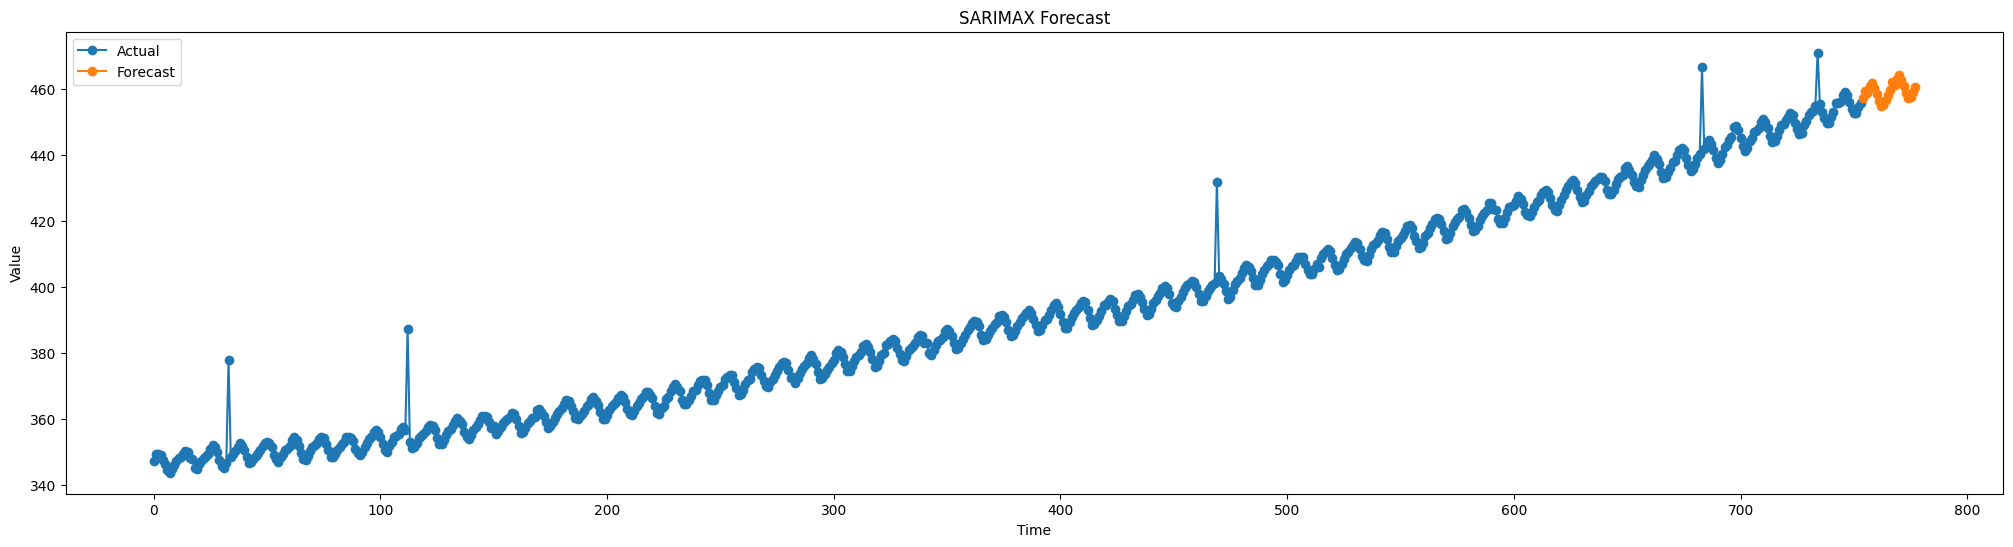

In [ ]:
model_name = 'SARIMAX'

plot_backtest(data['Value'], future_data['Predicted_Value'], model_name)

# **Machine Learning**

In [ ]:
def reframe_to_supervised(df:pd.Series, window_size=12):
    df_supervised = pd.DataFrame()

    # Define columns names
    X_columns = [f't-{window_size-i}' for i in range(window_size)]
    columns = X_columns + ['target']

    # Iterate
    for i in range(0, df.shape[0] - window_size):
        # Extract the last "window_size" observations and target
        # value and create an individual dataframe with this info
        df_supervised_i = pd.DataFrame([df.values[i:i+window_size+1]],
                                      columns=columns,
                                      index=[df.index[i+window_size]])

        # Add to the final dataframe
        df_supervised = pd.concat((df_supervised, df_supervised_i),
                                   axis=0)
    return df_supervised

In [ ]:
training_proportion = 0.90

df = reframe_to_supervised(data['Value'], window_size)
n_obs = data.shape[0]
n_train = int(n_obs * training_proportion)

# Training set
train = df.iloc[:n_train]
# Testing set
test = df.iloc[n_train:]

X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test.drop('target', axis=1)
y_test = test['target']

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:03<00:00, 12.08it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
Ridge                                        0.73       0.78   2.59   
BayesianRidge                                0.73       0.78   2.59   
LassoCV                                      0.73       0.78   2.60   
TransformedTargetRegressor                   0.73       0.78   2.60   
LinearRegression                             0.73       0.78   2.60   
LassoLarsCV                                  0.73       0.78   2.60   
LarsCV                                       0.73       0.78   2.60   
Lars                                         0.73       0.78   2.60   
LassoLarsIC                                  0.73       0.78   2.60   
SGDRegressor                                 0.73       0.78   2.62   
RidgeCV                                      0.73       0.78   2.62   
LinearSVR                                    0.72       0.77   2.65   
Orthog

**ML MODEL RMSE: 2.59**

In [ ]:
def tune_ridge_with_grid_search(X_train, y_train, cv=5, scoring='neg_mean_squared_error'):

    ridge = Ridge()
    alphas = [0, 0.01, 0.1, 1, 10, 100]
    solver = ['saga', 'svd', 'auto', 'cholesky', 'lsqr']

    param_grid = {'alpha': alphas,
                  'solver': solver}

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    return best_params, best_estimator

# Create a function to train and predict values for the next 24 months
window_size = 12

def predict_next_24_months(data, window_size, future_months=24):
    pred = []

    for i in range(future_months):
        df = reframe_to_supervised(data['Value'], window_size)

        # Create or retrain the model with the current data
        X_train = df.drop(columns=['target'])
        y_train = df['target']
        X_columns = X_train.columns
        best_params, best_estimator = tune_ridge_with_grid_search(X_train, y_train)

        test_data = data['Value'][-window_size:]
        test_df = pd.DataFrame(test_data.values.reshape(1, -1), columns=X_columns)

        # Now, we can make predictions
        predicted_value = best_estimator.predict(test_df)
        pred.append(predicted_value[0])

        new_data = pd.DataFrame({'Value': [predicted_value[0]]})
        data = pd.concat([data, new_data], ignore_index=True)

    return pred

ml_pred = predict_next_24_months(data, window_size, future_months=24)

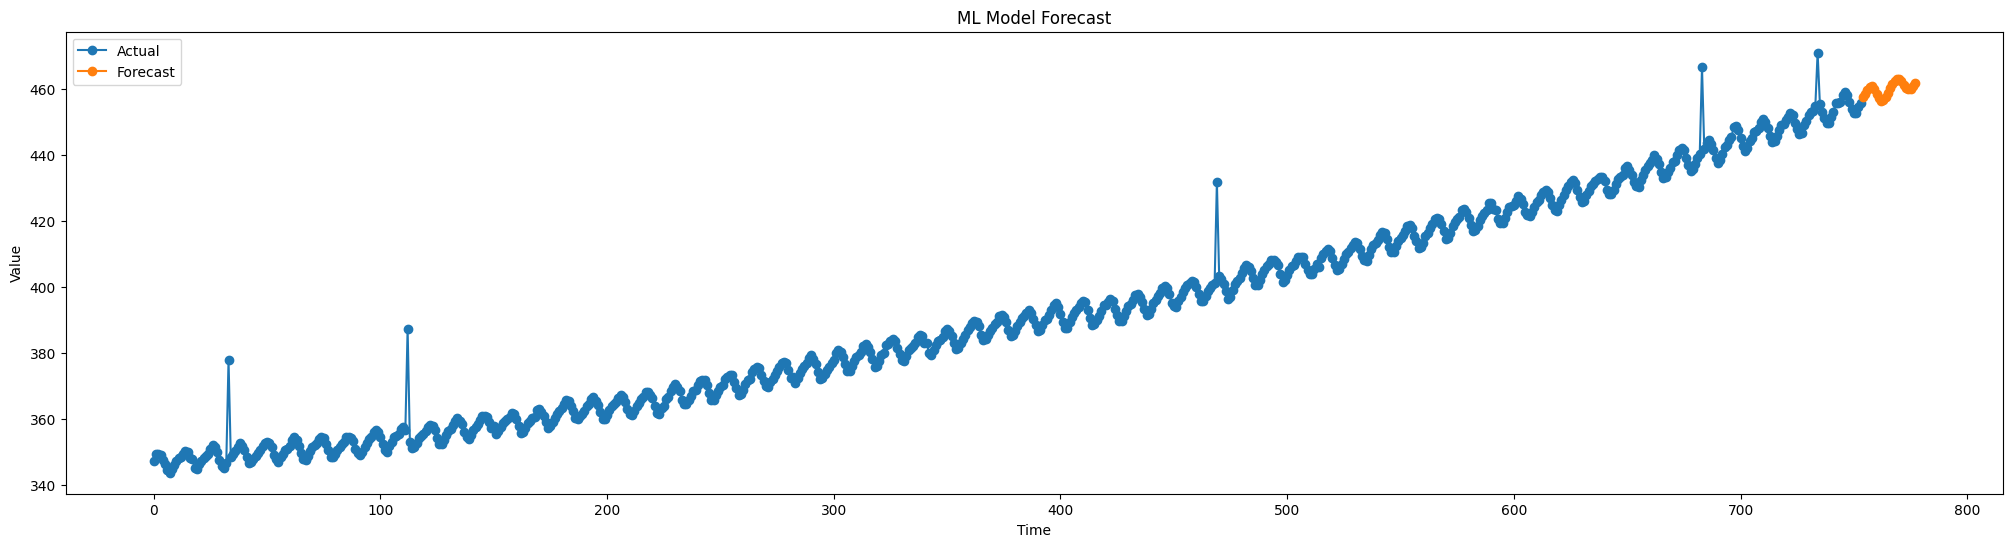

In [ ]:
future_data['Predicted_Value'] = ml_pred

model_name = 'ML Model'

plot_backtest(data['Value'], future_data['Predicted_Value'], model_name)

# **Deep Learning**

In [24]:
nobs = 12
df_train = data[['Value']].iloc[:-nobs]
df_test = data[['Value']].iloc[-nobs:]


scaler = StandardScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

n_inputs = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_inputs, batch_size=12)

In [50]:
model = Sequential([layers.Input((n_inputs, n_features)),
                    LSTM(128,return_sequences=True),
                    LSTM(128,return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),

                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(1)])


model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 12, 128)           66560     
                                                                 
 lstm_34 (LSTM)              (None, 12, 128)           131584    
                                                                 
 dropout_10 (Dropout)        (None, 12, 128)           0         
                                                                 
 lstm_35 (LSTM)              (None, 64)                49408     
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)               

In [51]:
model.fit(generator, epochs = 10)

Epoch 1/10
61/61 [==============================] - 13s 42ms/step - loss: 0.2133 - mse: 0.2133
Epoch 2/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0362 - mse: 0.0362
Epoch 3/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0243 - mse: 0.0243
Epoch 4/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0280 - mse: 0.0280
Epoch 5/10
61/61 [==============================] - 2s 41ms/step - loss: 0.0370 - mse: 0.0370
Epoch 6/10
61/61 [==============================] - 3s 44ms/step - loss: 0.0250 - mse: 0.0250
Epoch 7/10
61/61 [==============================] - 2s 33ms/step - loss: 0.0477 - mse: 0.0477
Epoch 8/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0241 - mse: 0.0241
Epoch 9/10
61/61 [==============================] - 2s 32ms/step - loss: 0.0189 - mse: 0.0189
Epoch 10/10
61/61 [==============================] - 2s 40ms/step - loss: 0.0254 - mse: 0.0254


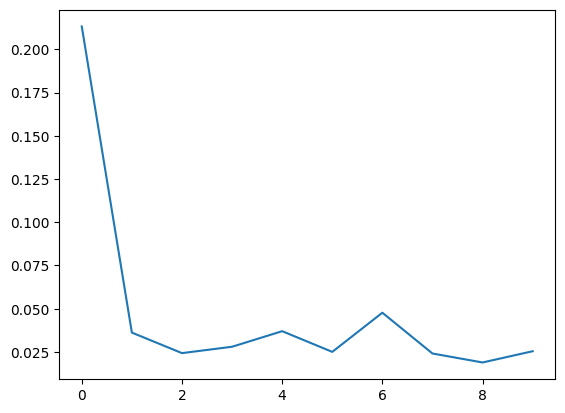

In [52]:
plt.plot(model.history.history['loss'])

In [53]:
y_pred = []

first_batch = scaled_train[-n_inputs:]
current_batch = first_batch.reshape(1, n_inputs, n_features)

for i in range(len(scaled_test)):
    batch = current_batch
    pred = model.predict(batch)[0]
    y_pred.append(pred)
    current_batch = np.append(current_batch[:,1:, :], [[pred]], axis = 1)

y_pred = scaler.inverse_transform(y_pred)
df_test['Predictions'] = y_pred

1/1 [==============================] - 0s 28ms/step


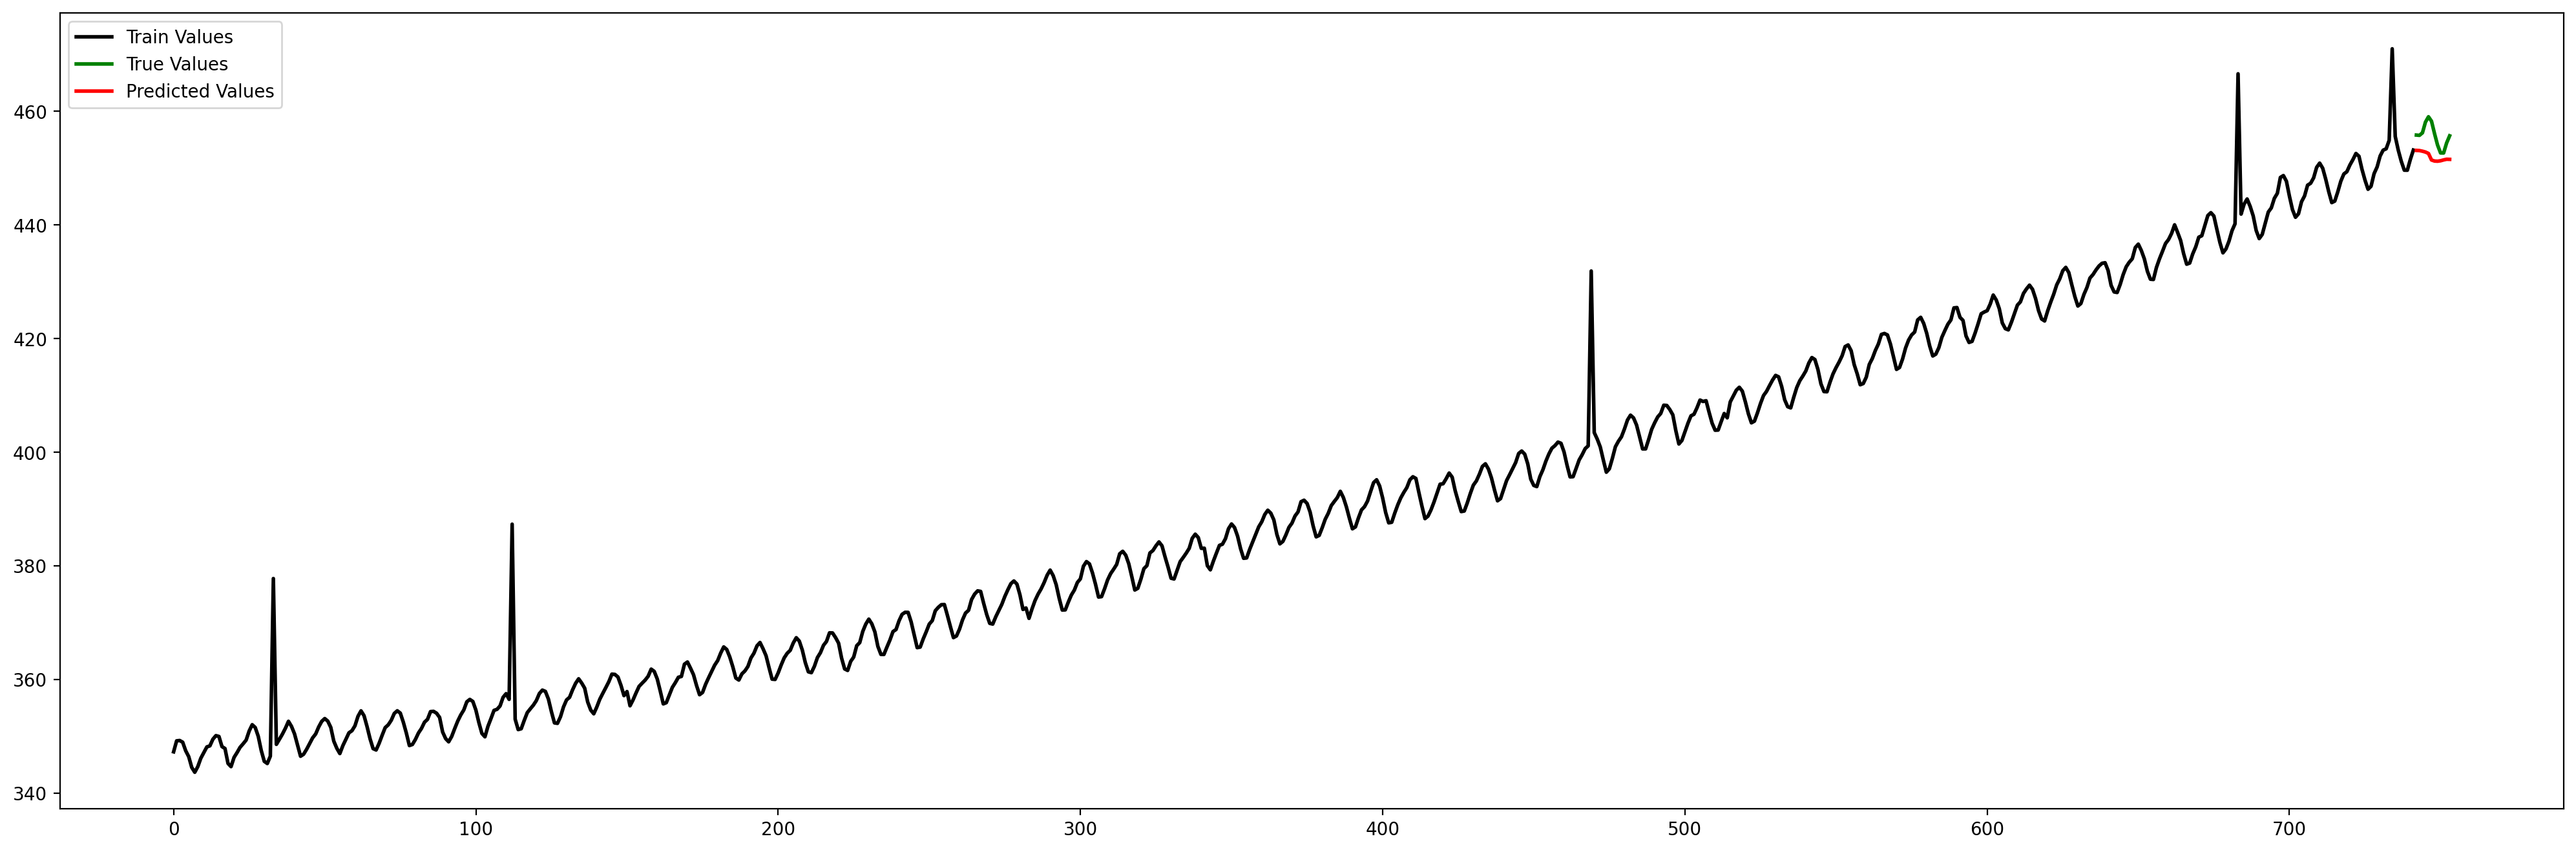

In [55]:
plt.figure(figsize=(25, 8), dpi=200)
plt.plot(df_train.index, df_train.Value, linewidth=2, color='black', label='Train Values')
plt.plot(df_test.index, df_test.Value, linewidth=2, color='green', label='True Values')
plt.plot(df_test.index, df_test.Predictions, linewidth=2, color='red', label='Predicted Values')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(df_test.Value, df_test.Predictions))

4.095308757878382

**DL RMSE: 4.1**

In [57]:
training_set = data[['Value']]
sc = StandardScaler()
train_scaled = sc.fit_transform(training_set)

n_input = 12
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=12)

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.3809988  -1.32088044 -1.31901148 -1.3283563  -1.37539191 -1.4074758
 -1.46665968 -1.49313667 -1.46229876 -1.41619763 -1.38504822 -1.35421031
 -1.32088044 -1.31901148 -1.3283563  -1.37539191 -1.4074758  -1.46665968
 -1.49313667 -1.46229876 -1.41619763 -1.38504822 -1.35421031 -1.34829192
 -1.31901148 -1.3283563  -1.37539191 -1.4074758  -1.46665968 -1.49313667
 -1.46229876 -1.41619763 -1.38504822 -1.35421031 -1.34829192 -1.31184711
 -1.3283563  -1.37539191 -1.4074758  -1.46665968 -1.49313667 -1.46229876
 -1.41619763 -1.38504822 -1.35421031 -1.34829192 -1.31184711 -1.29222299
 -1.37539191 -1.4074758  -1.46665968 -1.49313667 -1.46229876 -1.41619763
 -1.38504822 -1.35421031 -1.34829192 -1.31184711 -1.29222299 -1.2968954
 -1.4074758  -1.46665968 -1.49313667 -1.46229876 -1.41619763 -1.38504822
 -1.35421031 -1.34829192 -1.31184711 -1.29222299 -1.2968954  -1.35234135
 -1.46665968 -1.49313667 -1.46229876 -1.41619763 -1.38504822 -1.35421031
 -1.34829192 -1.31184711 -1.2922229

In [58]:
model = Sequential([layers.Input((n_inputs, n_features)),
                    LSTM(128,return_sequences=True),
                    LSTM(128,return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),

                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(1)])


model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 12, 128)           66560     
                                                                 
 lstm_37 (LSTM)              (None, 12, 128)           131584    
                                                                 
 dropout_11 (Dropout)        (None, 12, 128)           0         
                                                                 
 lstm_38 (LSTM)              (None, 64)                49408     
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 1)               

In [59]:
model.fit(generator, epochs = 10)

Epoch 1/10
62/62 [==============================] - 12s 32ms/step - loss: 0.2009 - mse: 0.2009
Epoch 2/10
62/62 [==============================] - 2s 31ms/step - loss: 0.0581 - mse: 0.0581
Epoch 3/10
62/62 [==============================] - 2s 35ms/step - loss: 0.0496 - mse: 0.0496
Epoch 4/10
62/62 [==============================] - 3s 43ms/step - loss: 0.0419 - mse: 0.0419
Epoch 5/10
62/62 [==============================] - 2s 34ms/step - loss: 0.0373 - mse: 0.0373
Epoch 6/10
62/62 [==============================] - 2s 35ms/step - loss: 0.0211 - mse: 0.0211
Epoch 7/10
62/62 [==============================] - 3s 41ms/step - loss: 0.0241 - mse: 0.0241
Epoch 8/10
62/62 [==============================] - 3s 48ms/step - loss: 0.0168 - mse: 0.0168
Epoch 9/10
62/62 [==============================] - 2s 34ms/step - loss: 0.0155 - mse: 0.0155
Epoch 10/10
62/62 [==============================] - 2s 33ms/step - loss: 0.0177 - mse: 0.0177


Text(0.5, 1.0, 'Loss per Epochs')

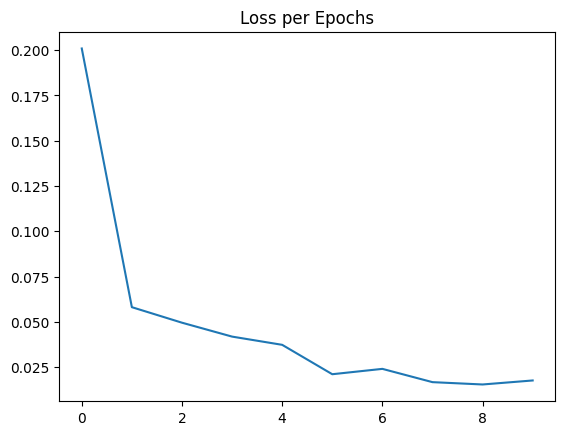

In [60]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [61]:
test_predictions =[]
first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for _ in range(24):
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    #append the prediction into the array
    test_predictions.append(current_pred)
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

1/1 [==============================] - 0s 29ms/step


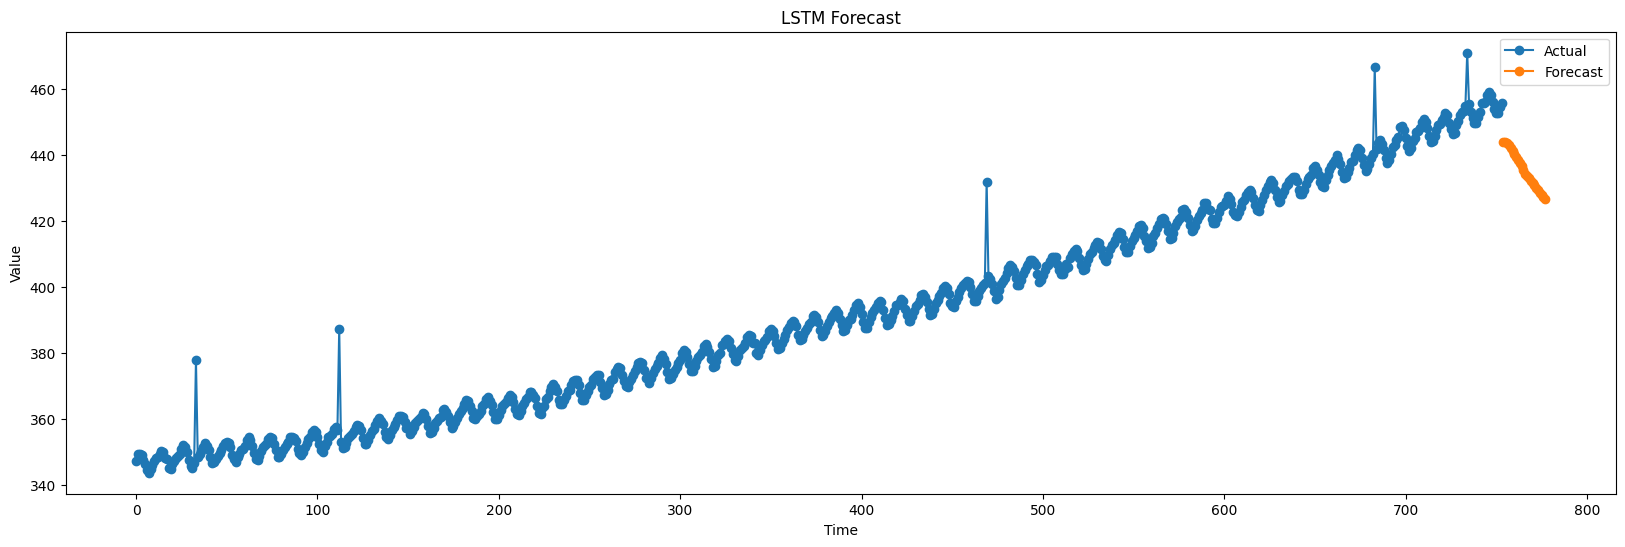

In [63]:
true_predictions = sc.inverse_transform(test_predictions)
future_data['Predicted_Value'] = true_predictions
model_name = 'LSTM'

plot_backtest(data['Value'], future_data['Predicted_Value'], model_name)

**Final Results: Weighted Ensemble of SARIMA and Triple Exponential Smoothing Predictions to leverage the strengths of each model. Weighted averaging can make predictions more robust in situations where individual models may produce outliers or incorrect results.**

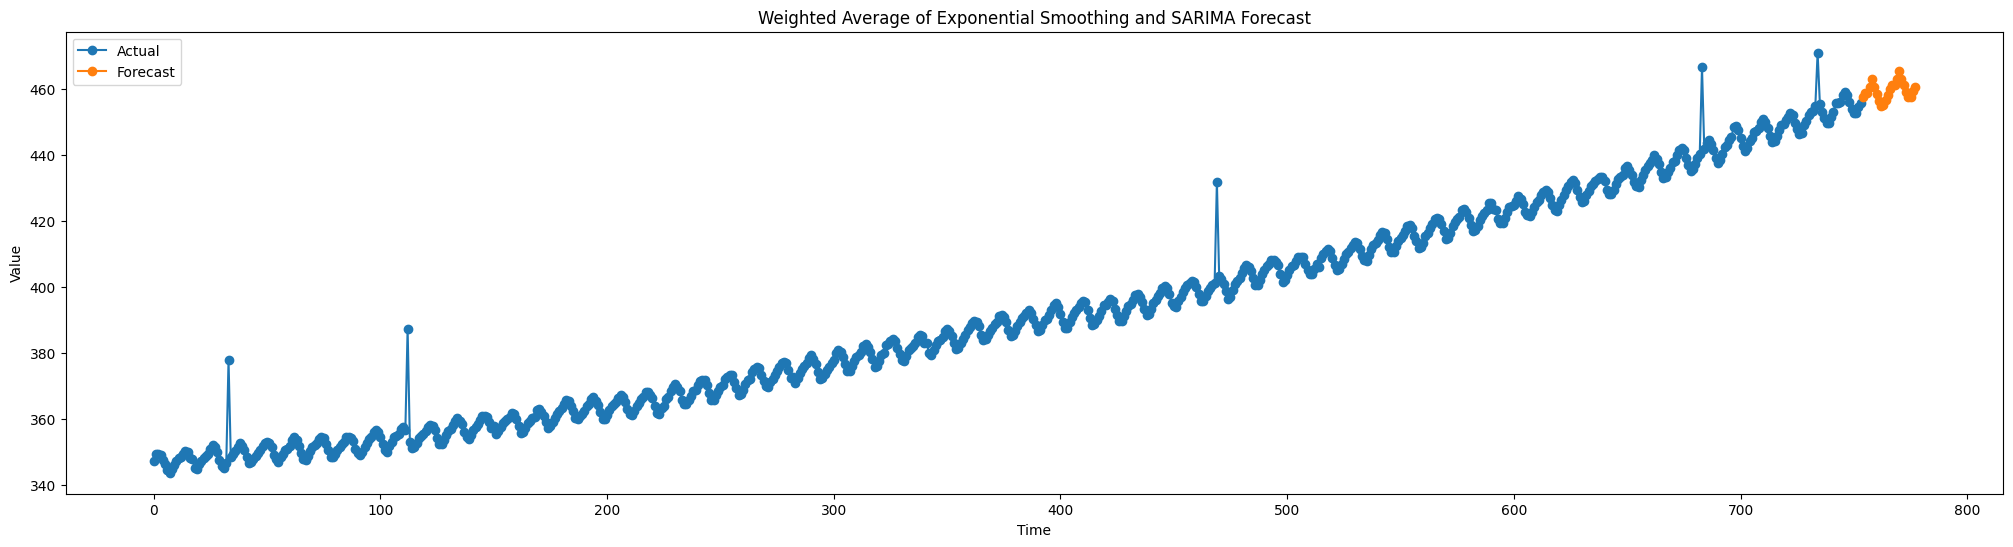

In [ ]:
weights = [0.5, 0.5]

# Combine predictions using a weighted average
future_data['Predicted_Value'] = (
    weights[0] * np.array(sarima_preds) +
    weights[1] * np.array(exp_smoothing_preds)
)

model_name = 'Weighted Average of Exponential Smoothing and SARIMA'

plot_backtest(data['Value'], future_data['Predicted_Value'], model_name)

In [ ]:
test = pd.read_csv("test.csv")

submission = pd.DataFrame(columns=['id', 'Label'])
submission['id'] = test['id']
submission['Label'] = future_data['Predicted_Value']

submission.to_csv('submission.csv', index=False)

# **Thank You.!**